<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/task_77slice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
import nibabel as nib
from IPython.display import clear_output
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import random

In [26]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [27]:
imgs_dir='/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_jpg/'
all_dirs = glob (f'{imgs_dir}/*')
len (all_dirs)
all_dirs.sort()

In [28]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def shuffle_split(all_dirs, val_pct=0.1, test_pct=0.1, seed=42):
    seed_everything(seed)
    n_test = int(len(all_dirs) * test_pct)
    n_val = int(len(all_dirs) * val_pct)
    idx = np.random.permutation(len(all_dirs))
    all_dirs = np.array(all_dirs)[idx]
    test_dirs = all_dirs[:n_test]
    valid_dirs = all_dirs[n_test:n_test + n_val]
    train_dirs = all_dirs[n_test + n_val:]
    return train_dirs, valid_dirs, test_dirs

In [29]:
train_dirs, valid_dirs, test_dirs = shuffle_split(all_dirs)
print(len(train_dirs), len(valid_dirs), len(test_dirs))

297 36 36


In [30]:
class BratsDataset (Dataset):
    def __init__ (self, img_dirs, modality_types, transform = None):
        self.img_dirs = img_dirs
        self.transform = transform
        self.modality_types = modality_types

    def __len__ (self):
        return len (self.img_dirs)

    def __getitem__(self, index):
        imgs_path = self.img_dirs[index]
        patient_id = os.path.basename(imgs_path)
        image = self.concat_imgs(imgs_path)

        mask = np.array(Image.open(f'{imgs_path}/{patient_id}_seg-slice077.jpg'))
        mask = (mask / 255 * 4).round()
        mask = self.preprocess_mask_labels(mask)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

         # Select only the first channel from the mask
        mask = mask[..., 0]
        return image.astype(float), mask.astype(float)

    ## Spajanje slika s id-om pacijenta
    def concat_imgs(self, path: str):
      patient_id = os.path.basename(path)
      types = []
      for modality_type in modality_types:
          img = np.array(Image.open(f'{path}/{patient_id}_{modality_type}-slice077.jpg'))
          img = self.normalize(img)
          types.append(img)
      #return np.array(types)
      return np.array(types)[..., 0]

    ## Ova metoda pretvara izvornu masku segmentacije u one-hot kodiranu masku s četiri kanala koji predstavljaju različite regije tumora
    ## Cijeli tumor - WT, Tumorska jezgra - TC, Povećanje tumora - ET, Pozadina - BG
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = np.zeros(mask.shape)
        mask_WT[mask == 2] = 1

        mask_TC = np.zeros(mask.shape)
        mask_TC[mask == 1] = 1

        mask_ET = np.zeros(mask.shape)
        mask_ET[mask == 3] = 1

        mask_BG = np.zeros(mask.shape)
        mask_BG[mask == 0] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
        return mask

    ## Normalizacija ulaznih podataka
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        if np.max(data) == 0:
            return data
        if (np.max(data) - data_min) == 0:
            return data / data_min
        return (data - data_min) / (np.max(data) - data_min)

modality_types = ['flair', 't1', 't1ce', 't2']

In [31]:
batch_size = 8

#Datasets
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
test_ds = BratsDataset(test_dirs, modality_types)

#DataLoaders
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

print(len(train_dl),len(valid_dl), len(test_dl))

38 5 5


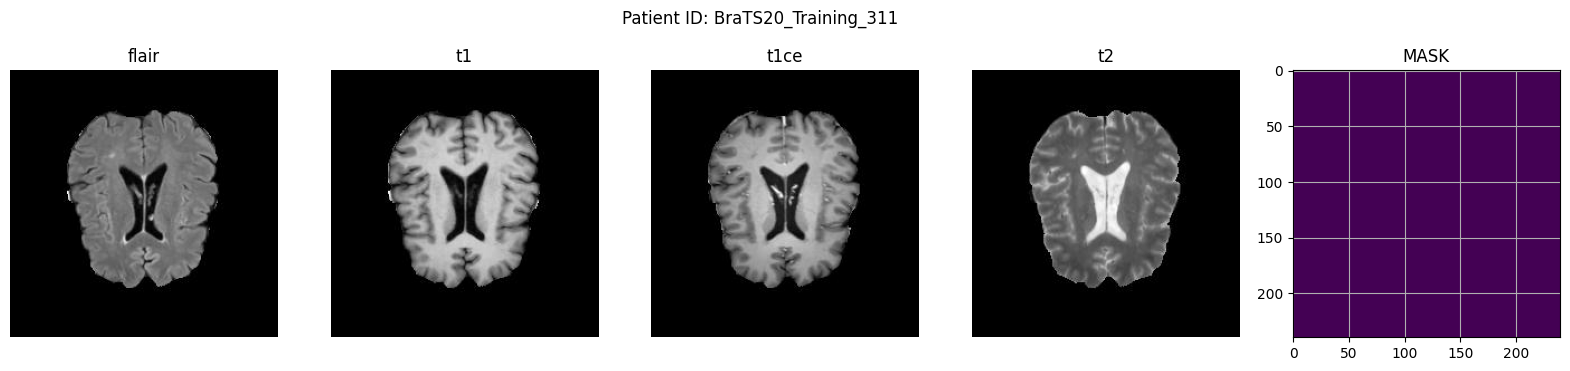

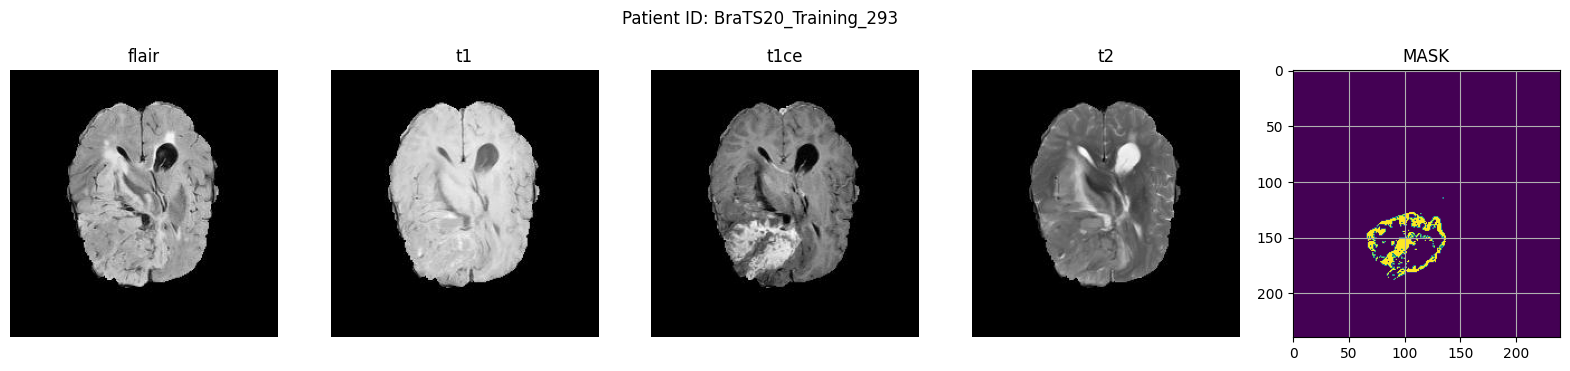

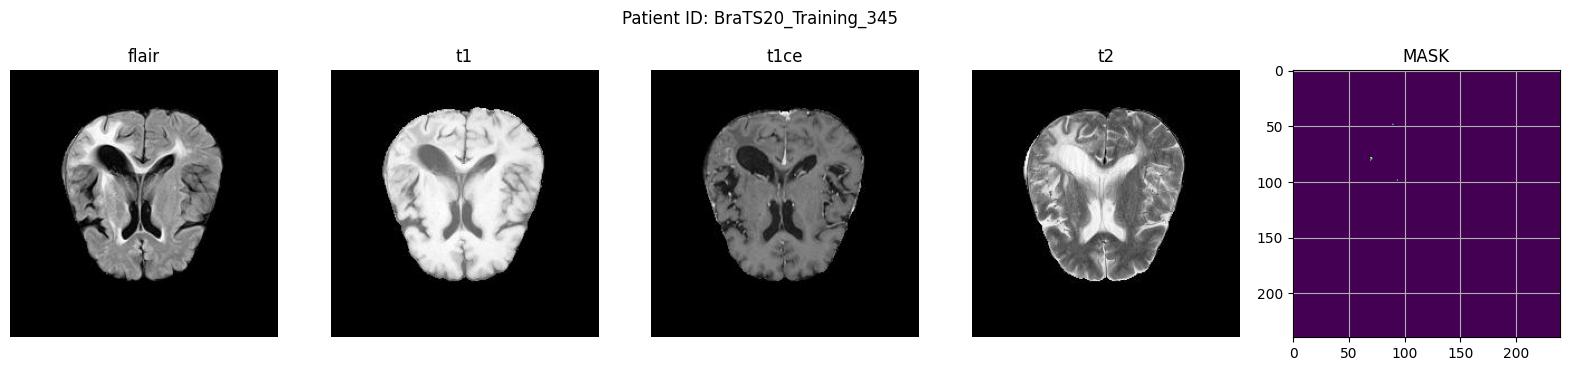

In [32]:
def visualize_samples(dataset, modality_types, num_samples):
    for i in range(num_samples):
        image, mask = dataset[i]

        # Extract patient ID
        patient_id = os.path.basename(dataset.img_dirs[i])

        # Create a single figure with one row and (len(modality_types) + 1) columns
        plt.figure(figsize=(20, 4))

        # Visualize all MRI modalities in the first len(modality_types) columns
        for j in range(len(modality_types)):
            plt.subplot(1, len(modality_types) + 1, j + 1)
            plt.imshow(image[j], cmap='gray')
            plt.axis('off')
            plt.title(f"{modality_types[j]}")

        # Visualize mask in the last column
        plt.subplot(1, len(modality_types) + 1, len(modality_types) + 1)
        plt.imshow(mask[1], cmap='viridis')
        plt.grid()
        plt.title("MASK")

        plt.suptitle(f"Patient ID: {patient_id}")
        plt.show()

visualize_samples(train_ds, modality_types, num_samples=3)

In [33]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.down5 = Down(1024,2048)

        self.up0 = Up(2048,1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)

        x = self.up0(x6,x5)
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [34]:
## Računa Dice koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti (probabilities) i stvarnih oznaka (truth)
## Dice koeficijent mjeri sličnost između predviđenih i stvarnih područja
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     threshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

## Računa Jaccard koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti i stvarnih oznaka
## Jaccard koeficijent mjeri sličnost između predviđenih i stvarnih područja
def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               threshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

In [35]:
## Klasa koja služi za praćenje i ažuriranje Dice i Jaccard koeficijenata tijekom evaluacije modela
class Meter:
    def __init__(self, threshold: float = 0.5):
        self.threshold: float = threshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

In [36]:
def bce_dice_loss(input, target, alpha, beta, smooth=1):
    # BCE loss
    bce_loss = F.binary_cross_entropy_with_logits(input, target)

    # Dice loss
    input = torch.sigmoid(input)
    input_flat = input.view(-1)
    target_flat = target.view(-1)
    intersection = (input_flat * target_flat).sum()
    dice_loss = 1 - (2 * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)

    # Combined loss
    loss = alpha * bce_loss + beta * dice_loss

    return loss

In [37]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 valid_dl: DataLoader,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9,0.999))
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val"  : valid_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = bce_dice_loss(logits, targets, alpha=0.5, beta=0.5)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        for itr, (images, targets) in enumerate(tqdm(dataloader, desc=f"{phase} epoch {epoch + 1}/{self.num_epochs}")):
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        print(f"Loss: {epoch_loss:.4f} | Dice: {epoch_dice:.4f} | IoU: {epoch_iou:.4f}")
        return epoch_loss

    ## Pokretanje treniranja kroz sve epohe
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()

    ## Prikaz grafa gubitaka, Dice i Jaccard koeficijenata tijekom treninga i validacije
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['pink', 'violet']
        labels = [
            f"Train Loss: {self.losses['train'][-1]:.4f} \nValidation Loss: {self.losses['val'][-1]:.4f}",
            f"Train Dice: {self.dice_scores['train'][-1]:.4f} \nValidation Dice: {self.dice_scores['val'][-1]:.4f}",
            f"Train Jaccard: {self.jaccard_scores['train'][-1]:.4f} \nValidation Jaccard: {self.jaccard_scores['val'][-1]:.4f}"
        ]

        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="Validation")
                ax.plot(data[i]['train'], c=colors[1], label="Training")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

In [38]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=4, n_classes=4).to(device)

In [39]:
trainer = Trainer(net = model,
                  train_dl = train_dl,
                  valid_dl = valid_dl,
                  lr = 1e-5,
                  accumulation_steps = batch_size,
                  batch_size = batch_size,
                  num_epochs = 30,
                 )

device: cuda


train epoch 1/30: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.6606 | Dice: 0.3684 | IoU: 0.2363


val epoch 1/30: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Loss: 0.6630 | Dice: 0.6172 | IoU: 0.4466


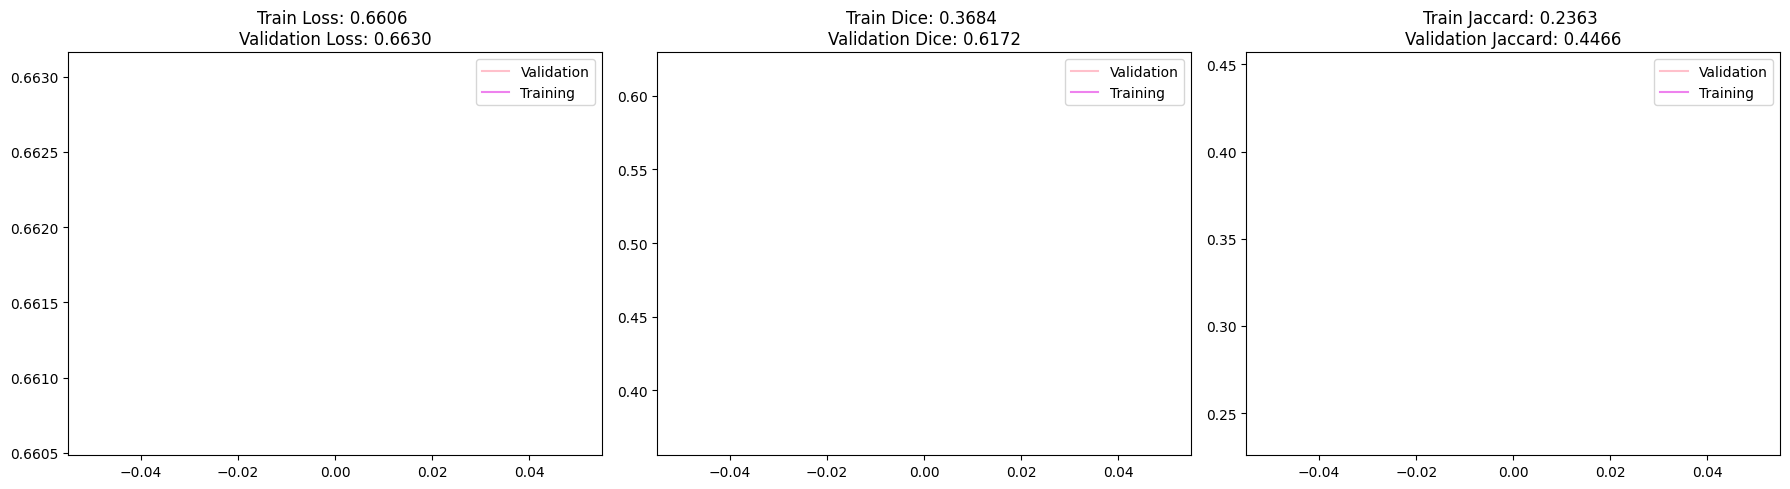

train epoch 2/30: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.6281 | Dice: 0.6544 | IoU: 0.4893


val epoch 2/30: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Loss: 0.6097 | Dice: 0.7938 | IoU: 0.6596


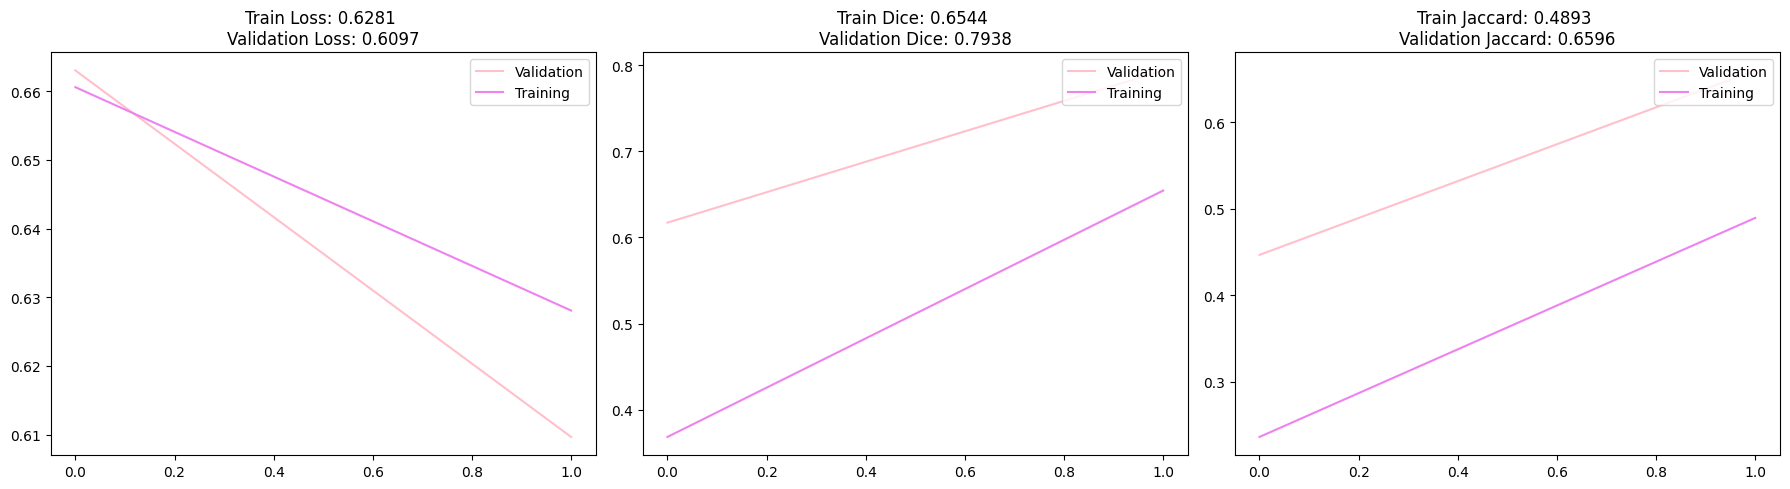

train epoch 3/30: 100%|██████████| 38/38 [00:28<00:00,  1.34it/s]


Loss: 0.6037 | Dice: 0.7549 | IoU: 0.6074


val epoch 3/30: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Loss: 0.5919 | Dice: 0.8034 | IoU: 0.6723


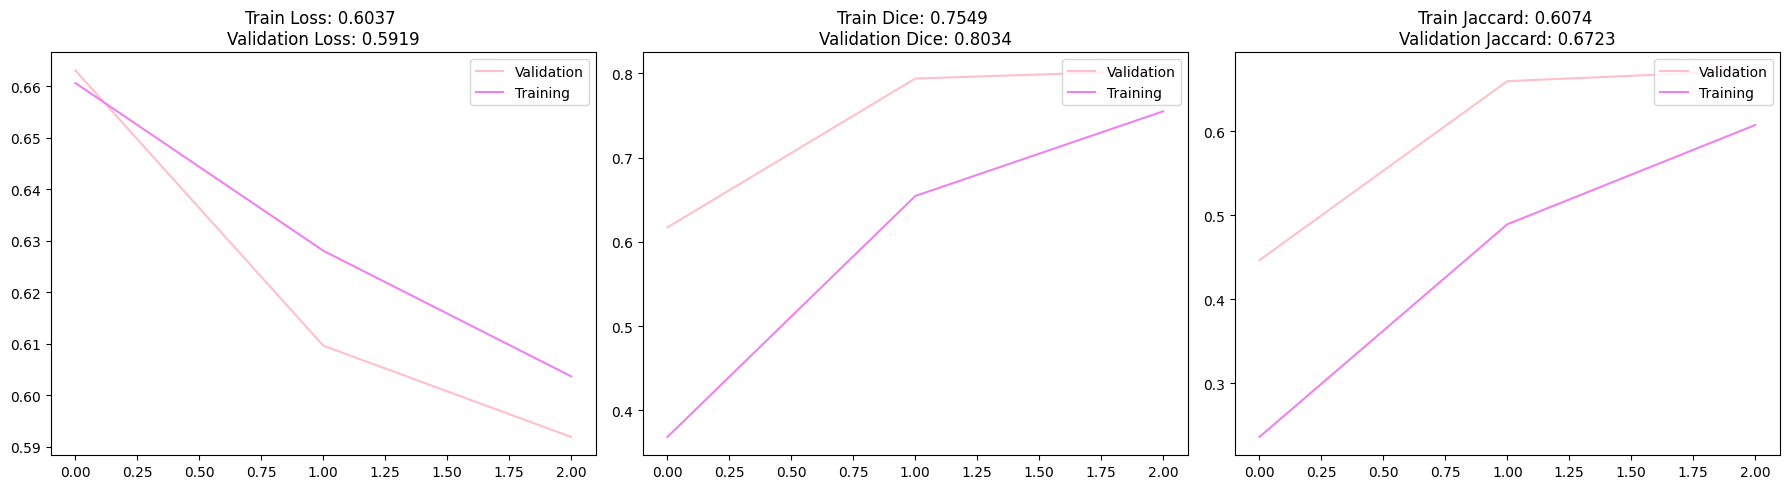

train epoch 4/30: 100%|██████████| 38/38 [00:28<00:00,  1.36it/s]


Loss: 0.5848 | Dice: 0.8097 | IoU: 0.6811


val epoch 4/30: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Loss: 0.5761 | Dice: 0.8473 | IoU: 0.7358


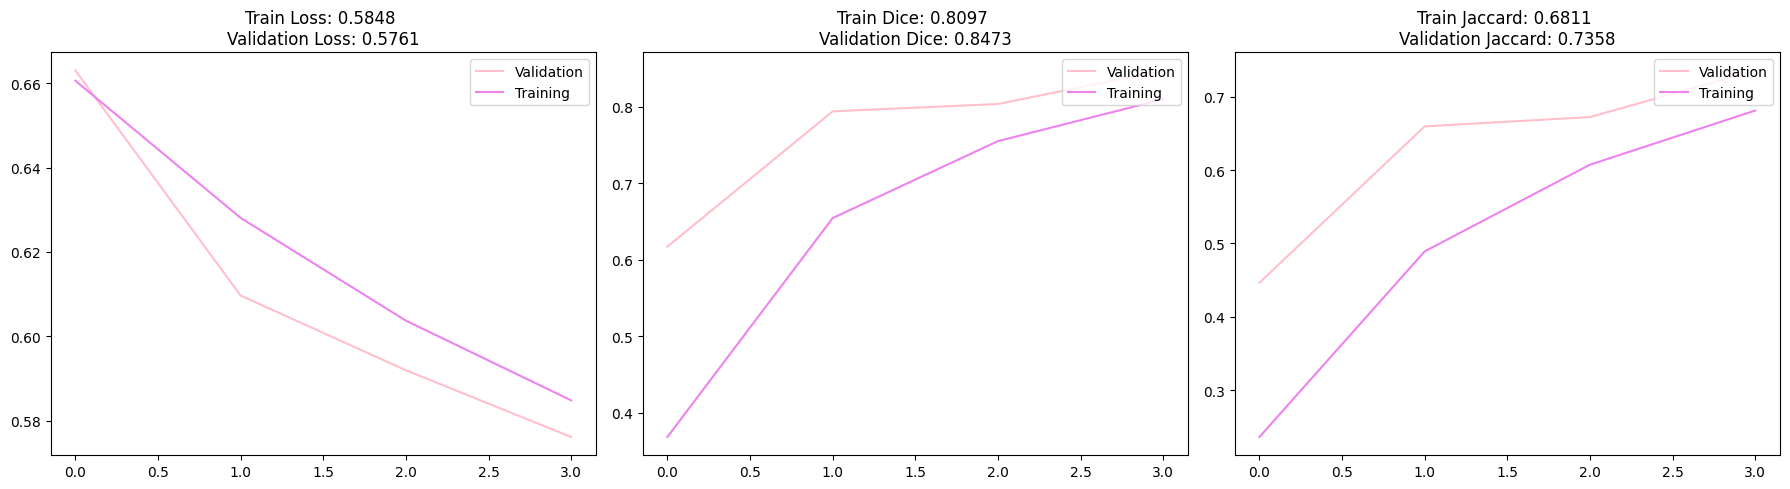

train epoch 5/30: 100%|██████████| 38/38 [00:28<00:00,  1.34it/s]


Loss: 0.5713 | Dice: 0.8499 | IoU: 0.7396


val epoch 5/30: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Loss: 0.5670 | Dice: 0.8587 | IoU: 0.7535


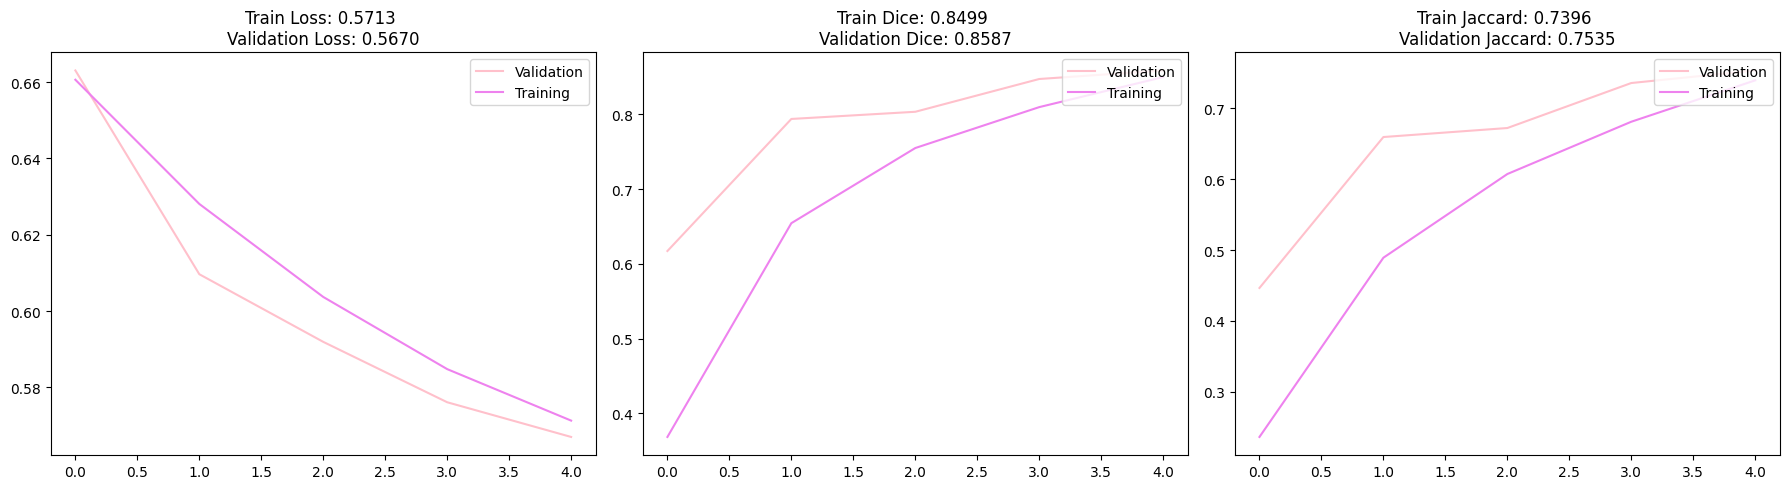

train epoch 6/30: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.5611 | Dice: 0.8564 | IoU: 0.7495


val epoch 6/30: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Loss: 0.5555 | Dice: 0.8190 | IoU: 0.6937


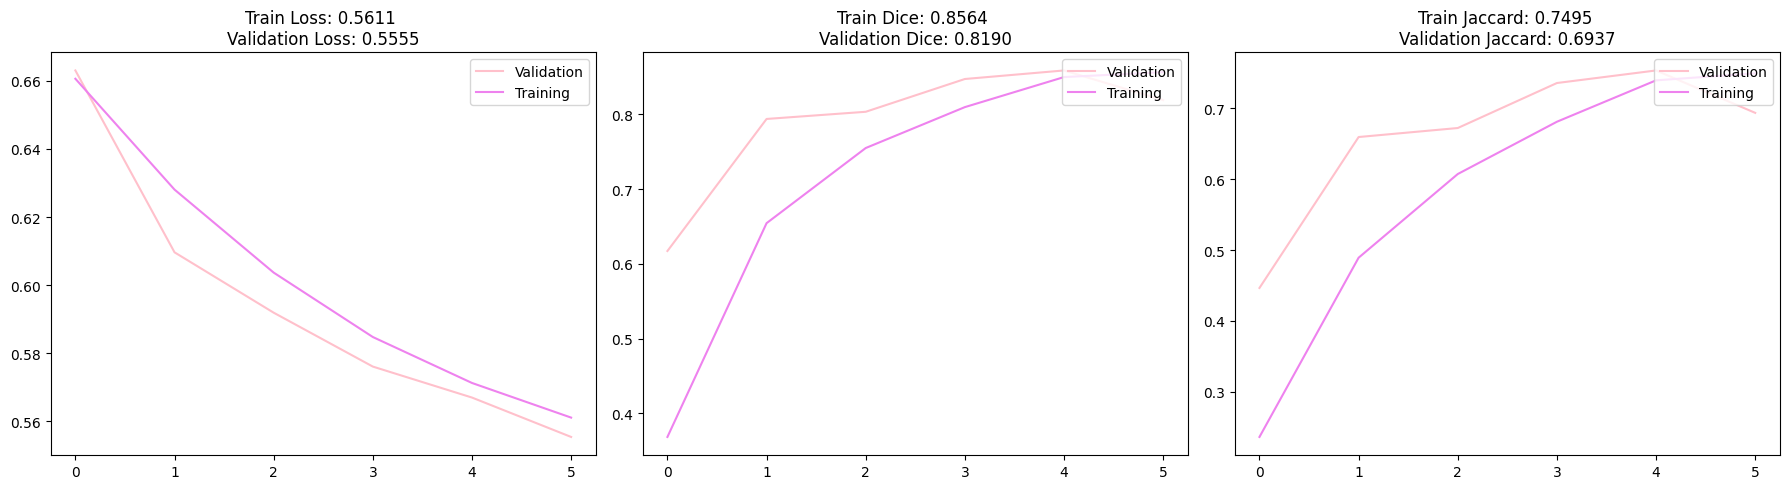

train epoch 7/30: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.5517 | Dice: 0.8258 | IoU: 0.7038


val epoch 7/30: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


Loss: 0.5514 | Dice: 0.8154 | IoU: 0.6888


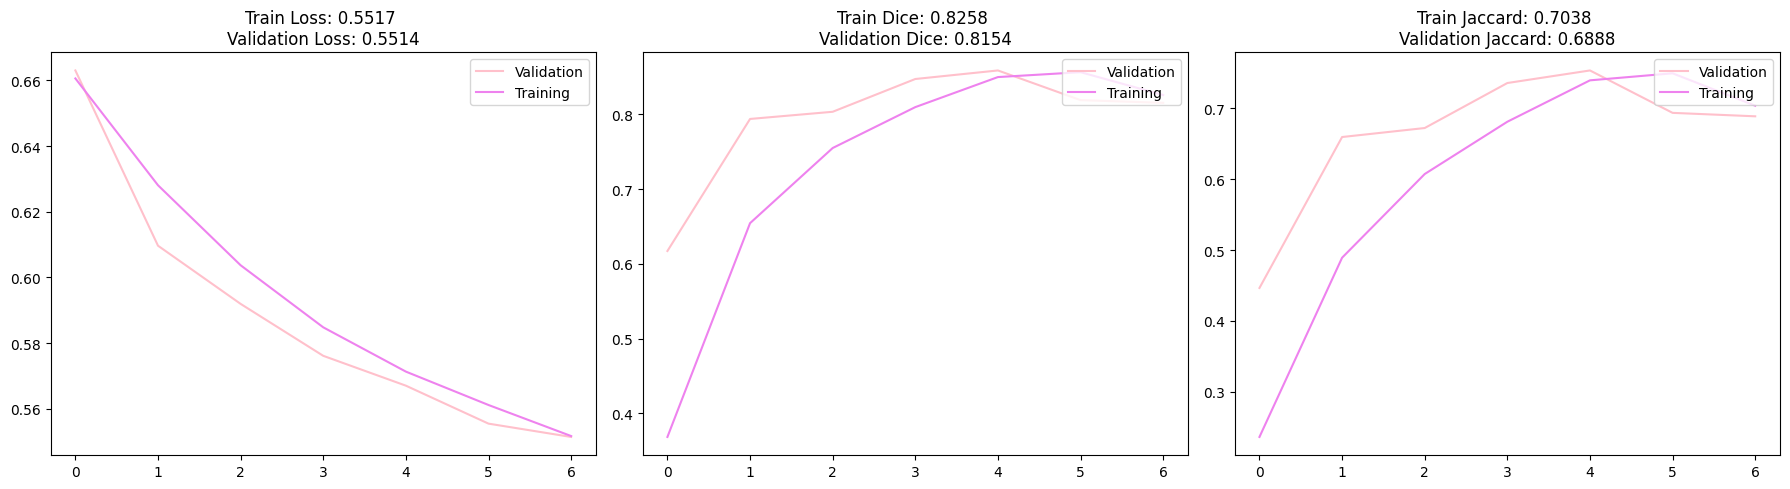

train epoch 8/30: 100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


Loss: 0.5444 | Dice: 0.8233 | IoU: 0.6998


val epoch 8/30: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Loss: 0.5420 | Dice: 0.8229 | IoU: 0.6993


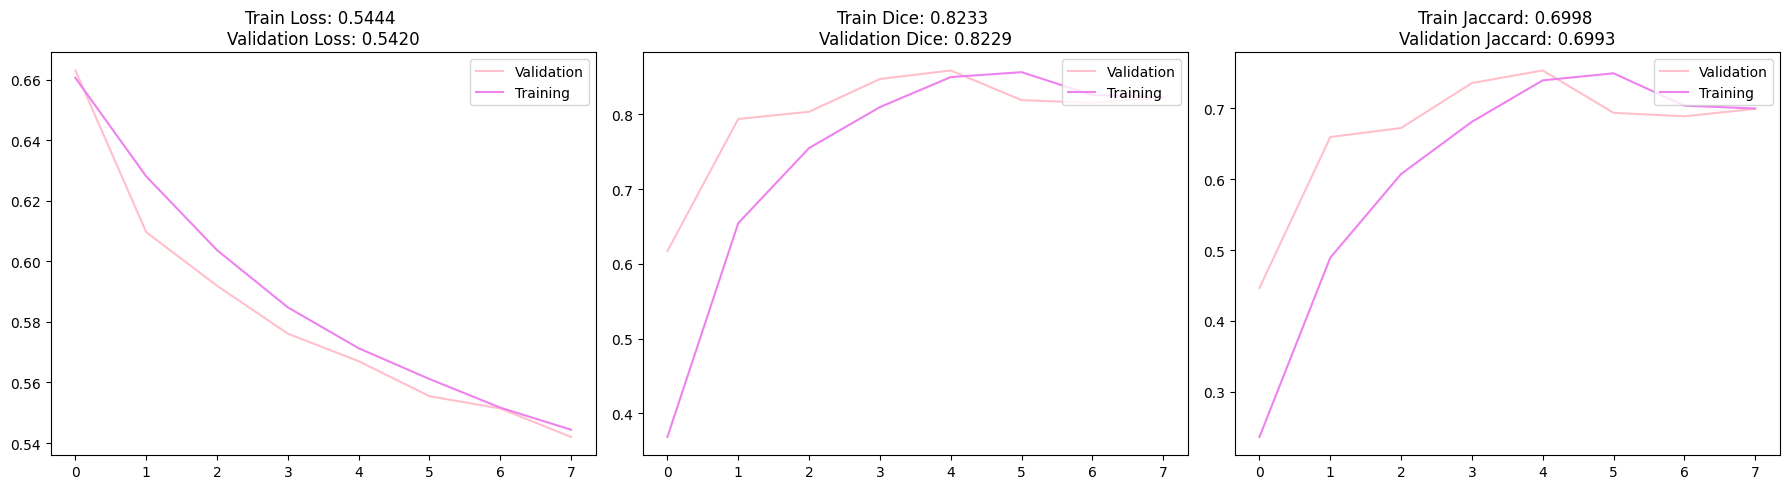

train epoch 9/30: 100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


Loss: 0.5385 | Dice: 0.8277 | IoU: 0.7063


val epoch 9/30: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Loss: 0.5377 | Dice: 0.8264 | IoU: 0.7045


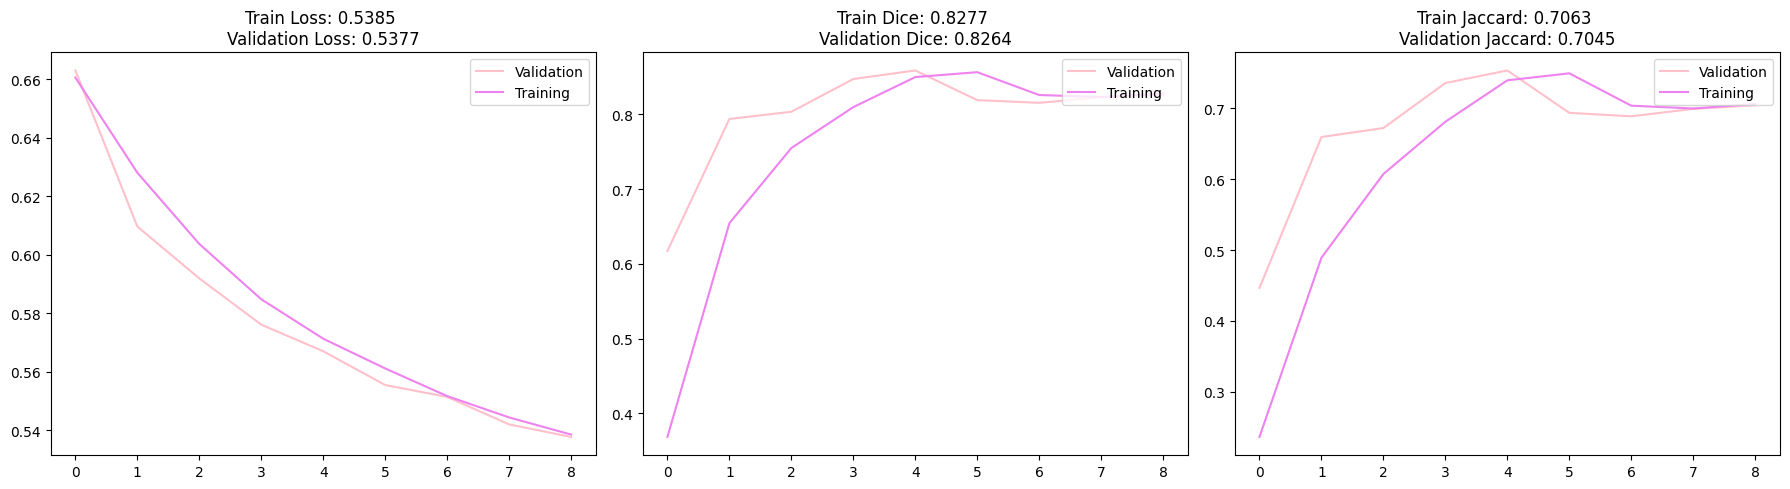

train epoch 10/30: 100%|██████████| 38/38 [00:28<00:00,  1.34it/s]


Loss: 0.5346 | Dice: 0.8387 | IoU: 0.7228


val epoch 10/30: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Loss: 0.5308 | Dice: 0.8524 | IoU: 0.7430


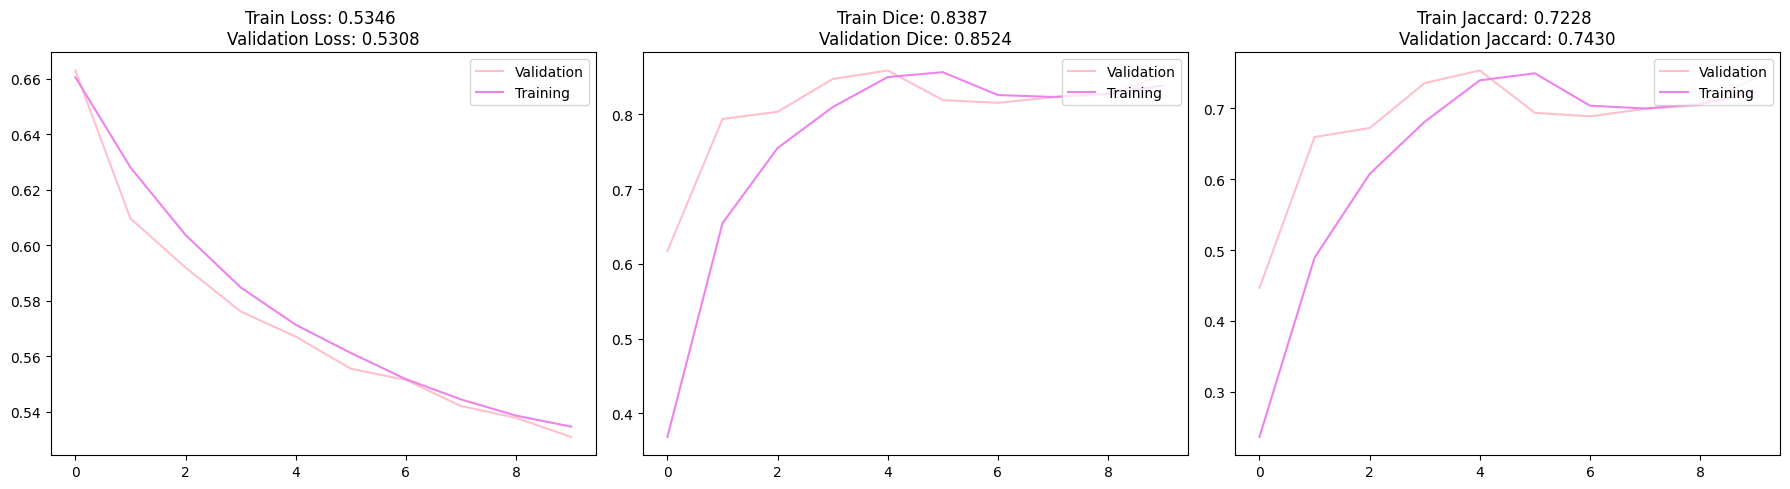

train epoch 11/30: 100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


Loss: 0.5294 | Dice: 0.8655 | IoU: 0.7639


val epoch 11/30: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Loss: 0.5267 | Dice: 0.8859 | IoU: 0.7954


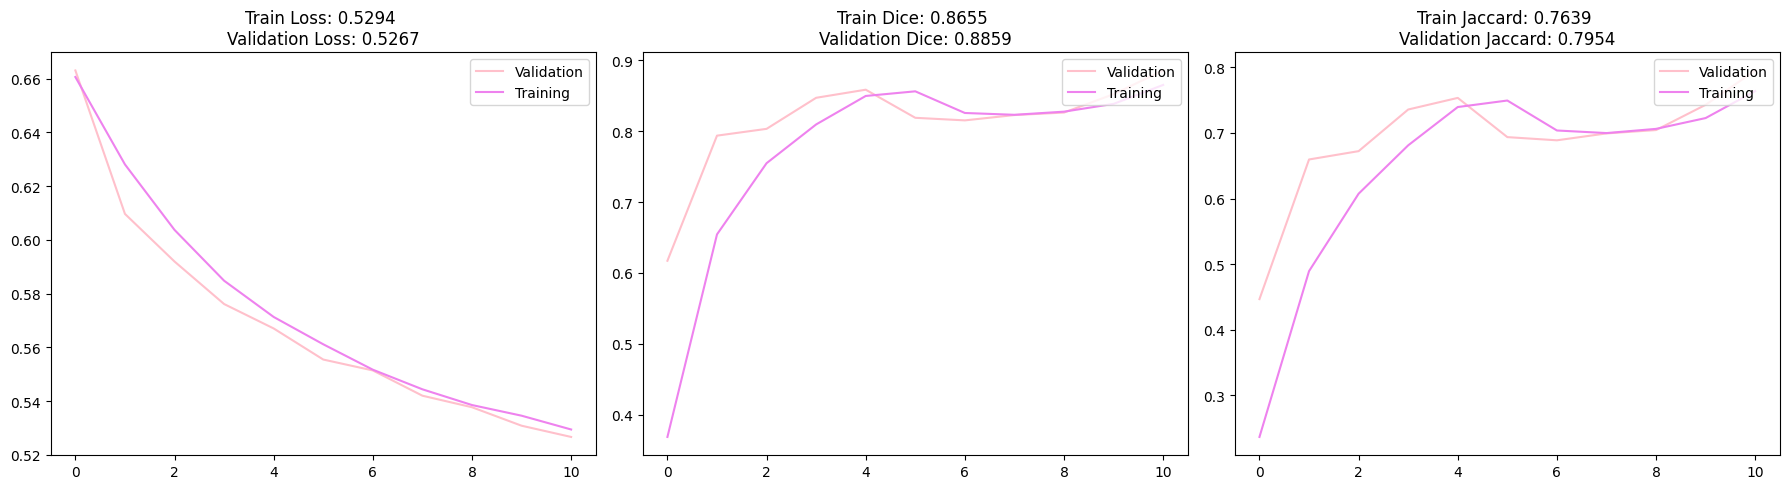

train epoch 12/30: 100%|██████████| 38/38 [00:27<00:00,  1.36it/s]


Loss: 0.5245 | Dice: 0.9112 | IoU: 0.8380


val epoch 12/30: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Loss: 0.5258 | Dice: 0.9360 | IoU: 0.8804


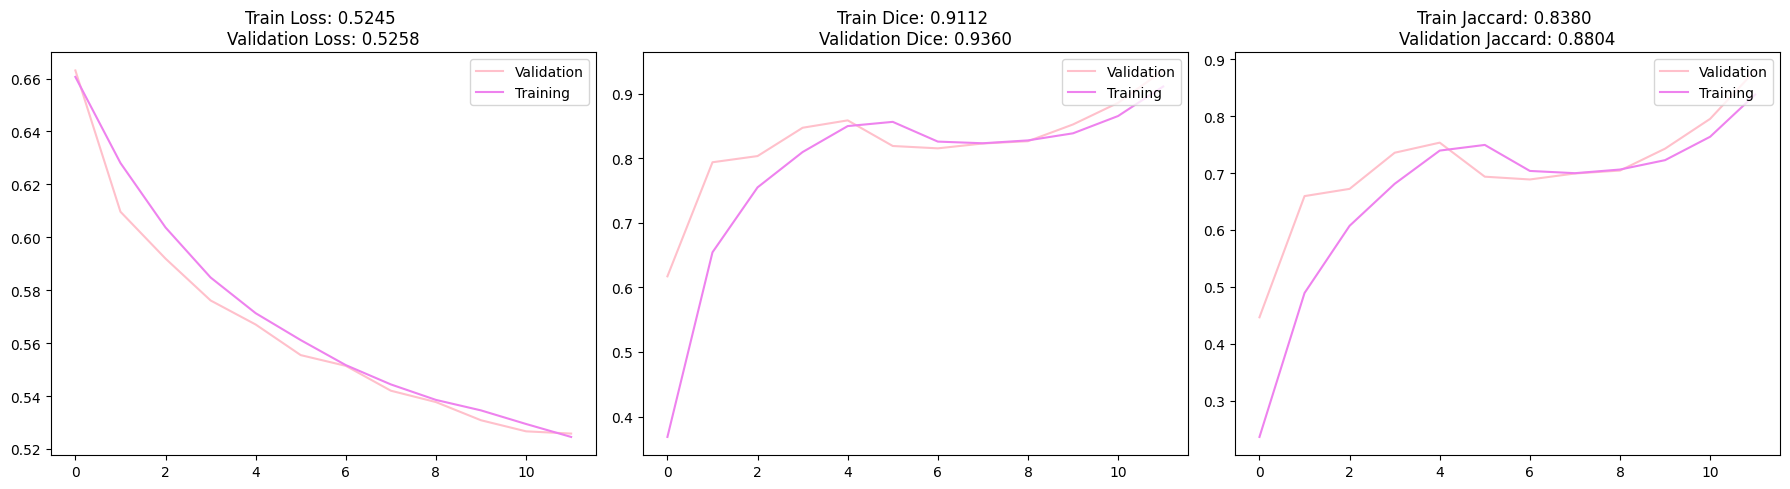

train epoch 13/30: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.5192 | Dice: 0.9489 | IoU: 0.9032


val epoch 13/30: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Loss: 0.5144 | Dice: 0.9505 | IoU: 0.9058


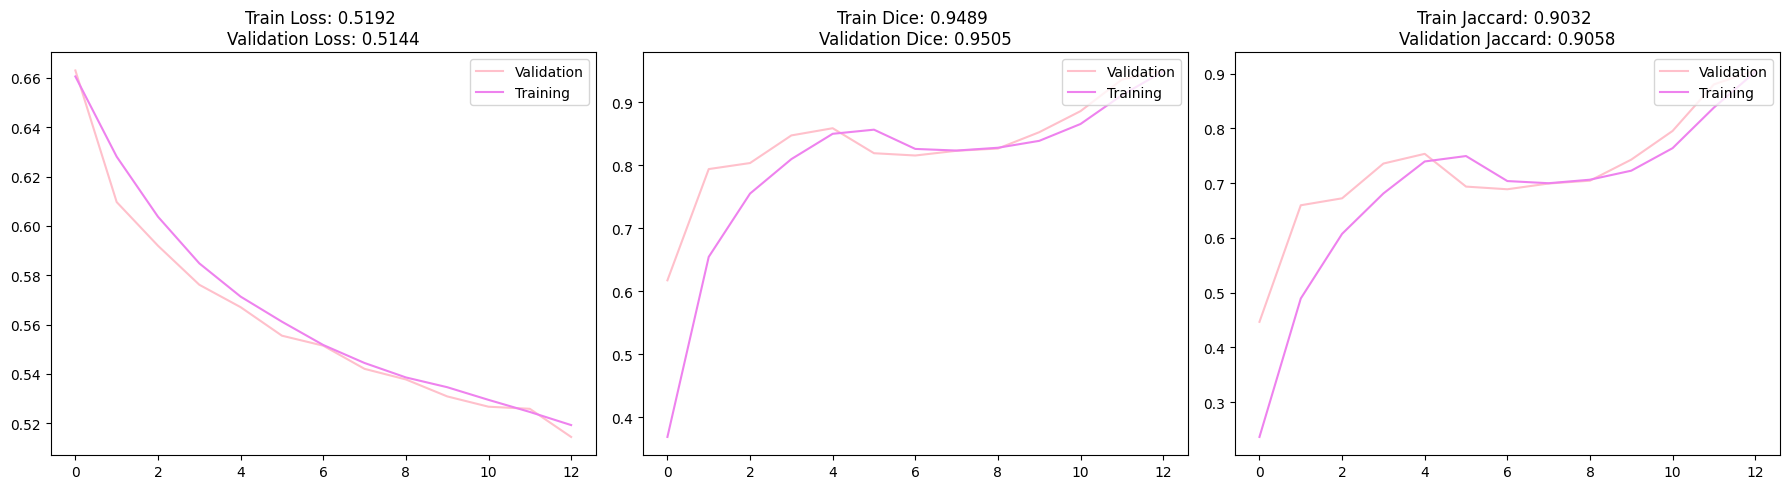

train epoch 14/30: 100%|██████████| 38/38 [00:27<00:00,  1.36it/s]


Loss: 0.5121 | Dice: 0.9566 | IoU: 0.9171


val epoch 14/30: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


Loss: 0.5083 | Dice: 0.9577 | IoU: 0.9192


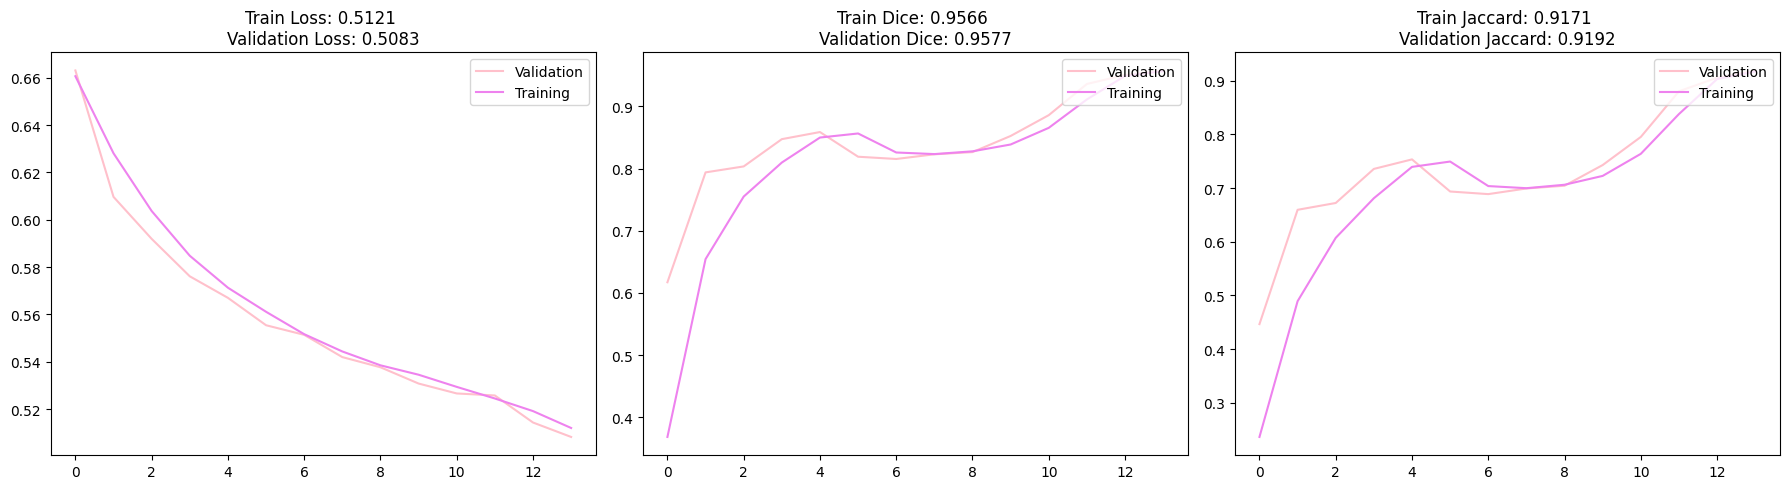

train epoch 15/30: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.5055 | Dice: 0.9622 | IoU: 0.9274


val epoch 15/30: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Loss: 0.5042 | Dice: 0.9622 | IoU: 0.9275


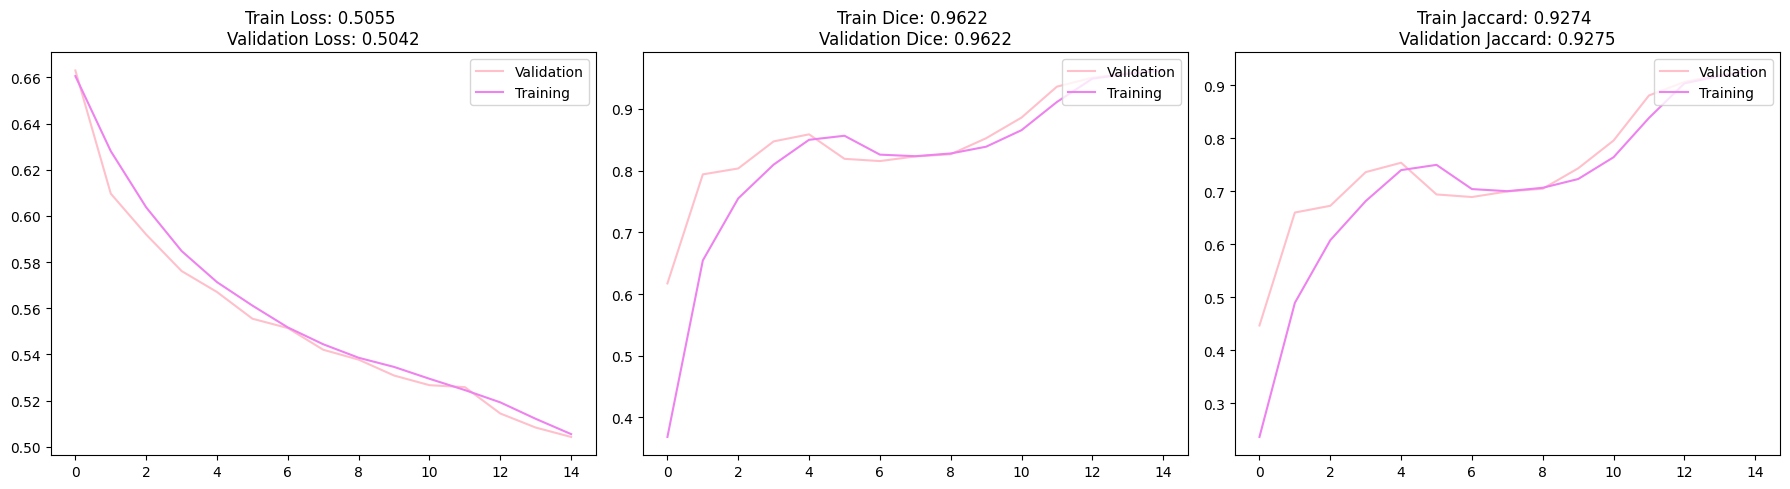

train epoch 16/30: 100%|██████████| 38/38 [00:28<00:00,  1.36it/s]


Loss: 0.5009 | Dice: 0.9645 | IoU: 0.9318


val epoch 16/30: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Loss: 0.5137 | Dice: 0.9469 | IoU: 0.9002


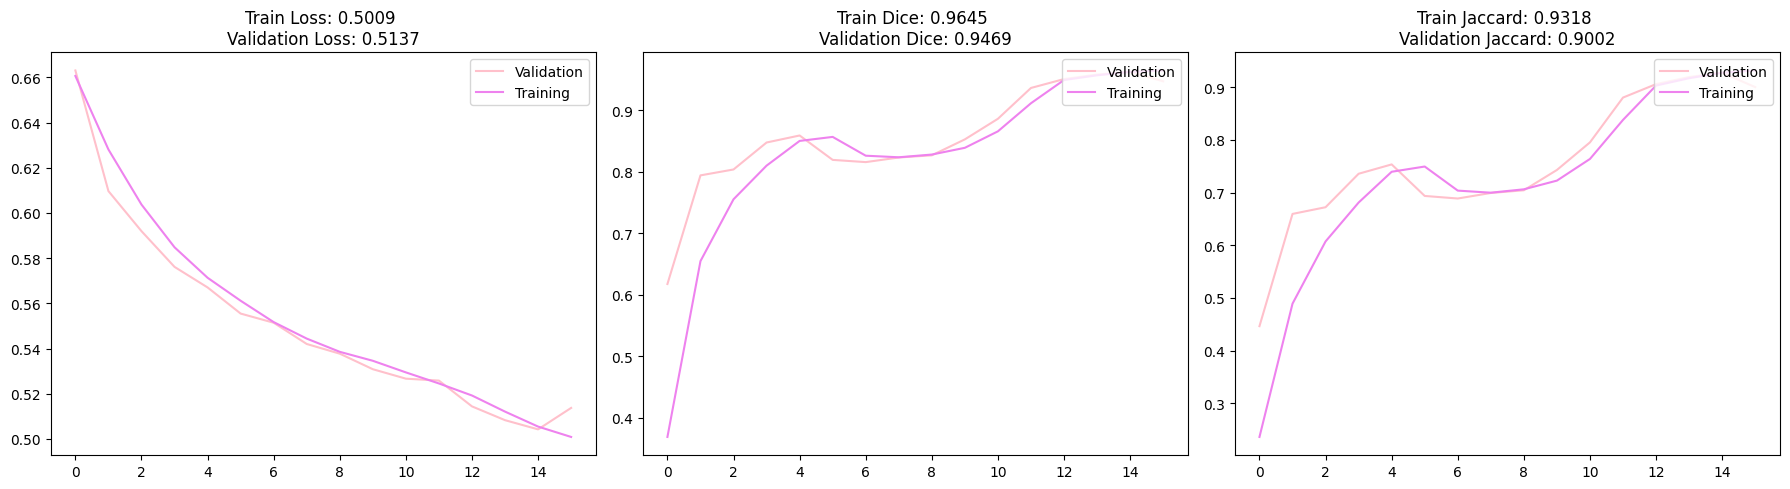

train epoch 17/30: 100%|██████████| 38/38 [00:27<00:00,  1.36it/s]


Loss: 0.4980 | Dice: 0.9626 | IoU: 0.9283


val epoch 17/30: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Loss: 0.4939 | Dice: 0.9708 | IoU: 0.9436


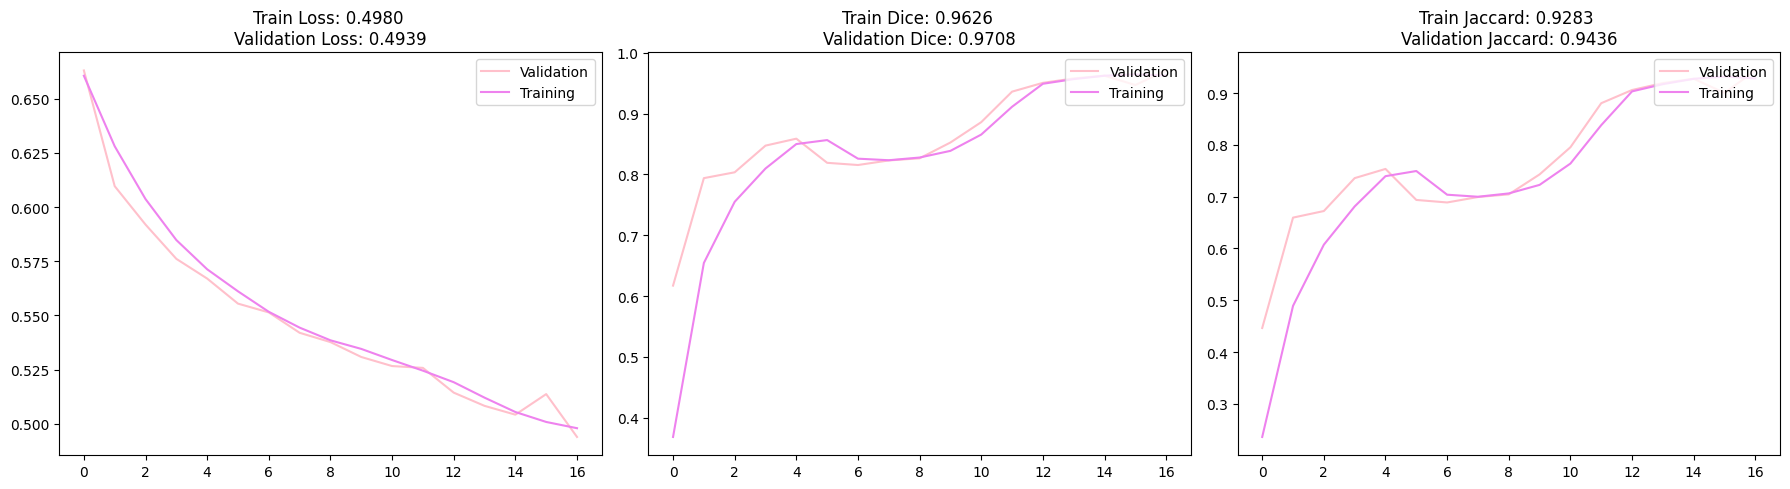

train epoch 18/30: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.4922 | Dice: 0.9686 | IoU: 0.9395


val epoch 18/30: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Loss: 0.4869 | Dice: 0.9710 | IoU: 0.9440


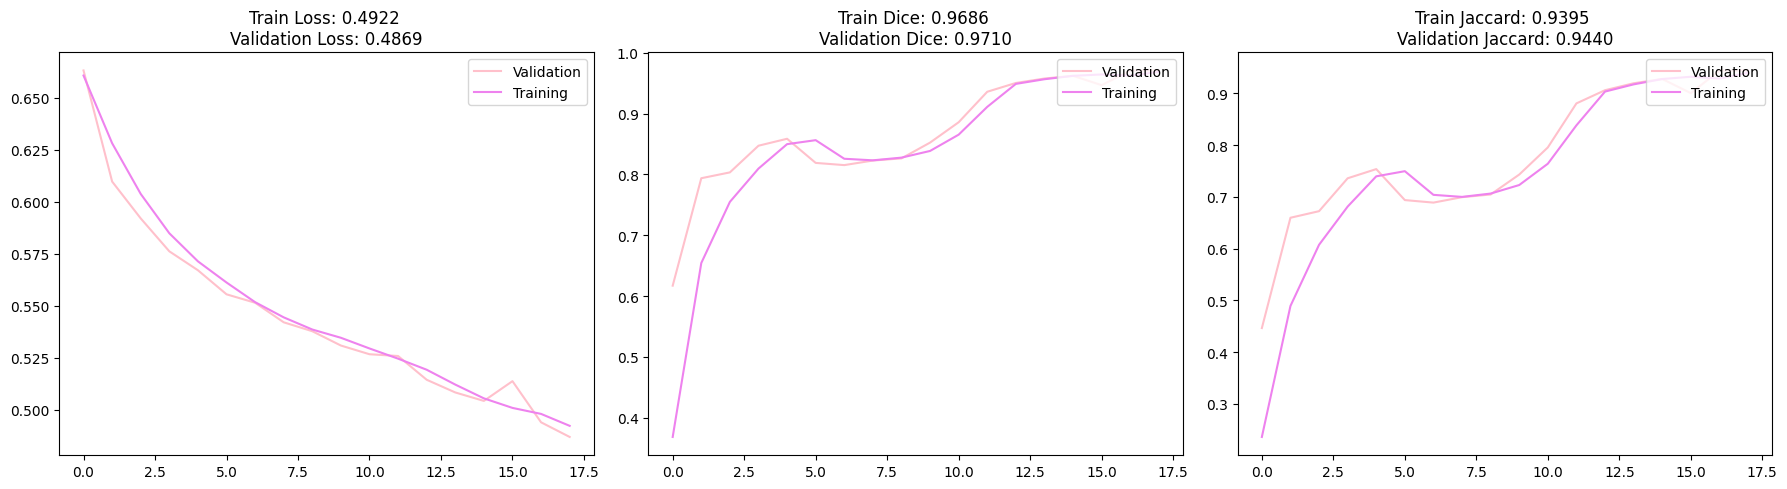

train epoch 19/30: 100%|██████████| 38/38 [00:28<00:00,  1.34it/s]


Loss: 0.4884 | Dice: 0.9713 | IoU: 0.9446


val epoch 19/30: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Loss: 0.4819 | Dice: 0.9746 | IoU: 0.9507


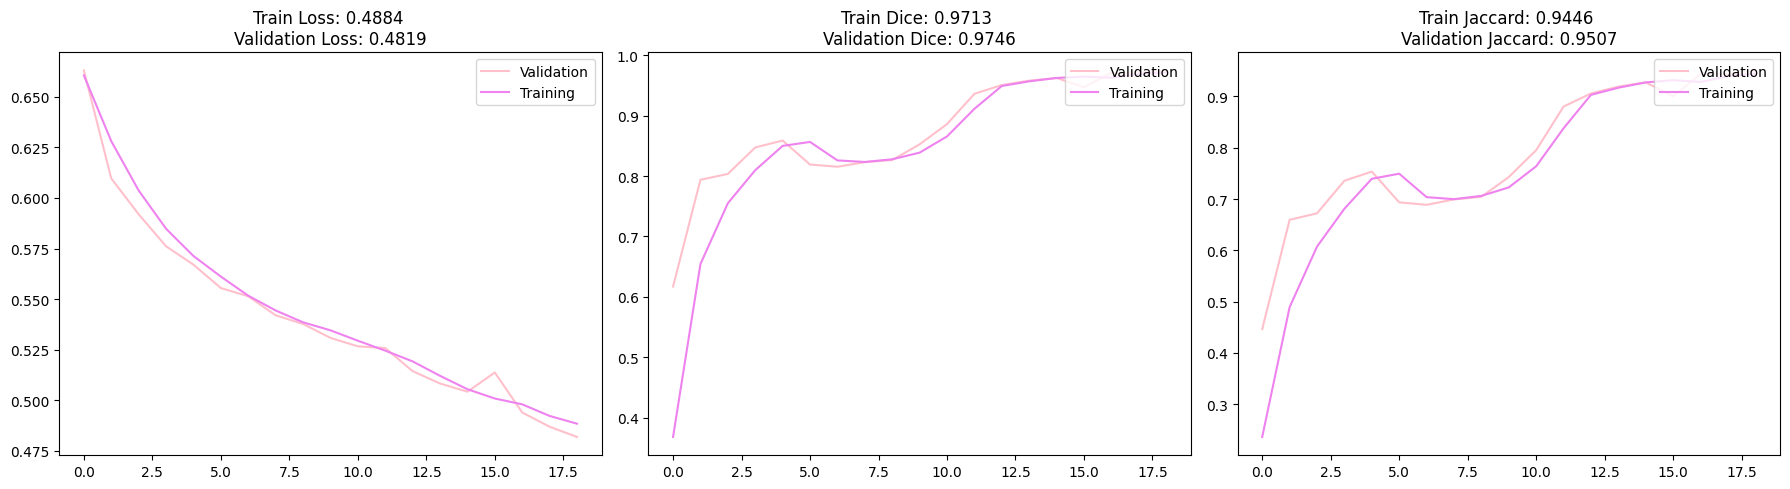

train epoch 20/30: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.4853 | Dice: 0.9725 | IoU: 0.9468


val epoch 20/30: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Loss: 0.4845 | Dice: 0.9744 | IoU: 0.9504


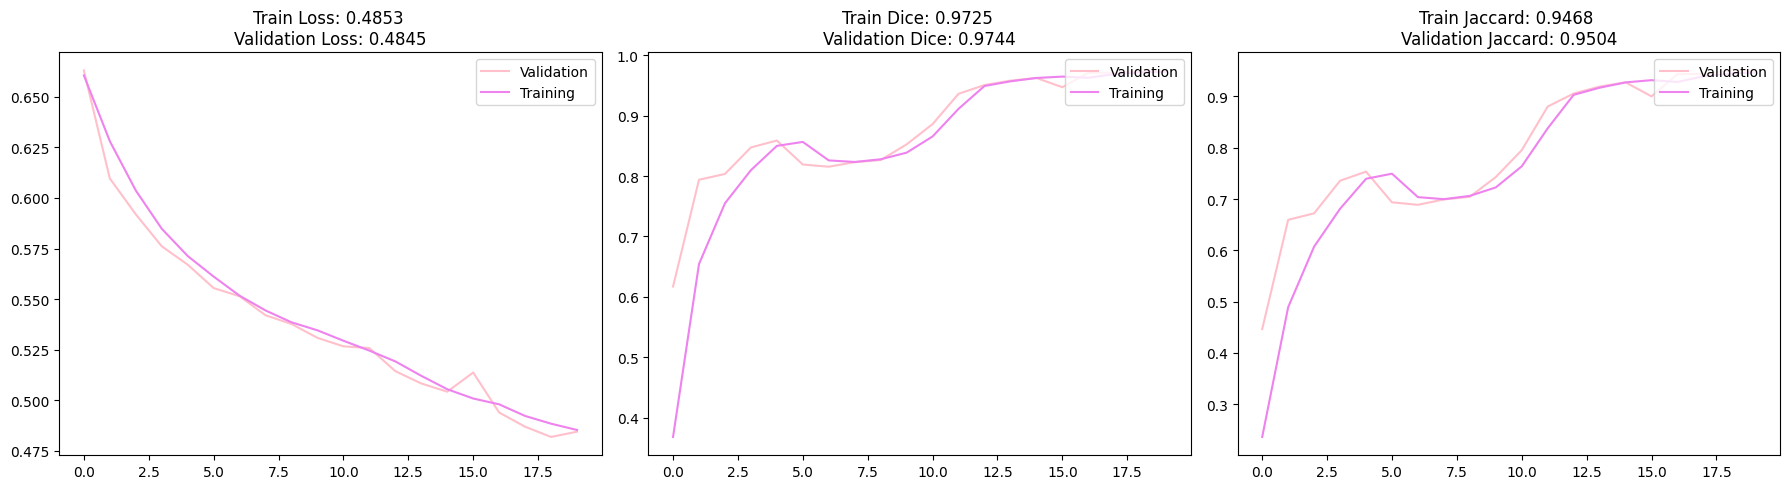

train epoch 21/30: 100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


Loss: 0.4820 | Dice: 0.9740 | IoU: 0.9497


val epoch 21/30: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


Loss: 0.4791 | Dice: 0.9748 | IoU: 0.9511


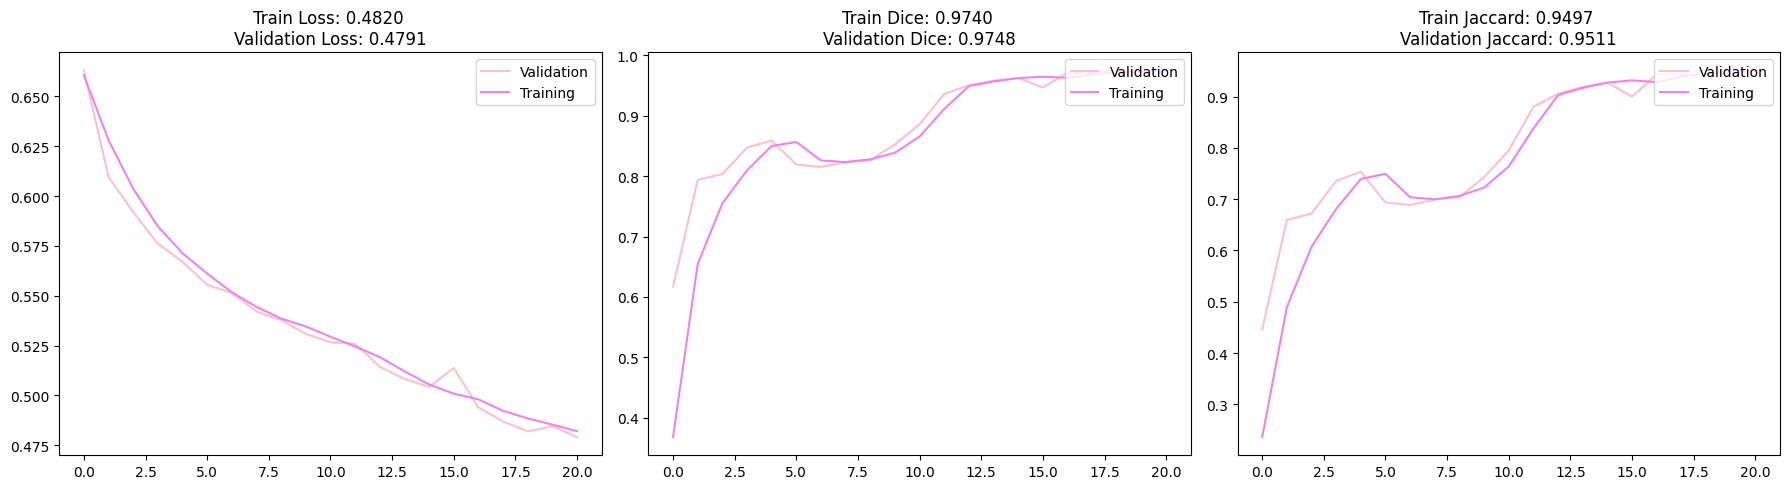

train epoch 22/30: 100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


Loss: 0.4783 | Dice: 0.9757 | IoU: 0.9529


val epoch 22/30: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Loss: 0.4756 | Dice: 0.9774 | IoU: 0.9560


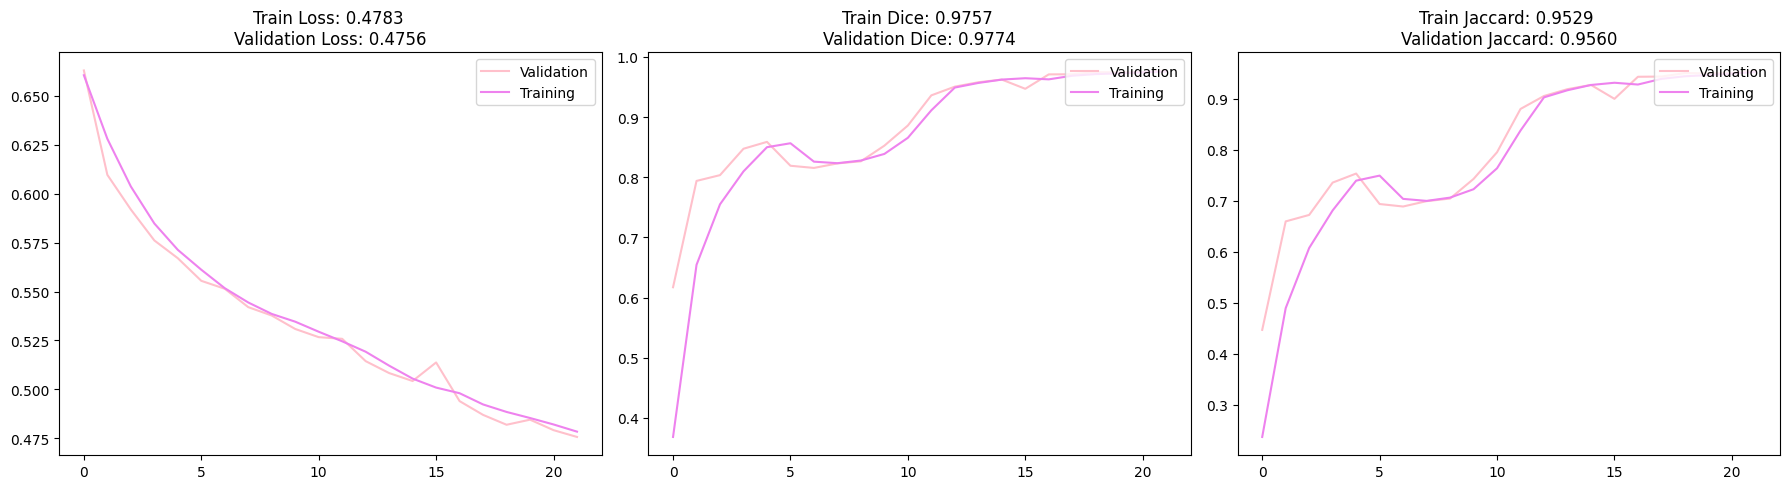

train epoch 23/30: 100%|██████████| 38/38 [00:28<00:00,  1.34it/s]


Loss: 0.4751 | Dice: 0.9758 | IoU: 0.9530


val epoch 23/30: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Loss: 0.4726 | Dice: 0.9779 | IoU: 0.9571


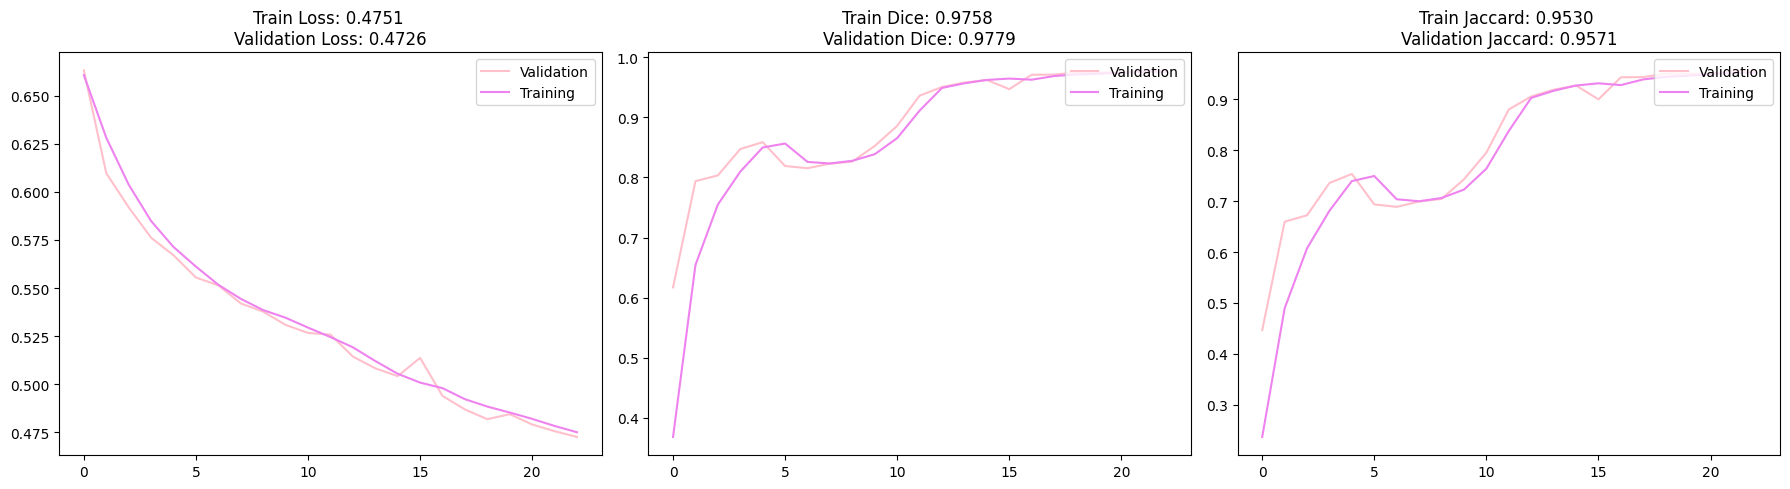

train epoch 24/30: 100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


Loss: 0.4721 | Dice: 0.9763 | IoU: 0.9539


val epoch 24/30: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Loss: 0.4697 | Dice: 0.9765 | IoU: 0.9543


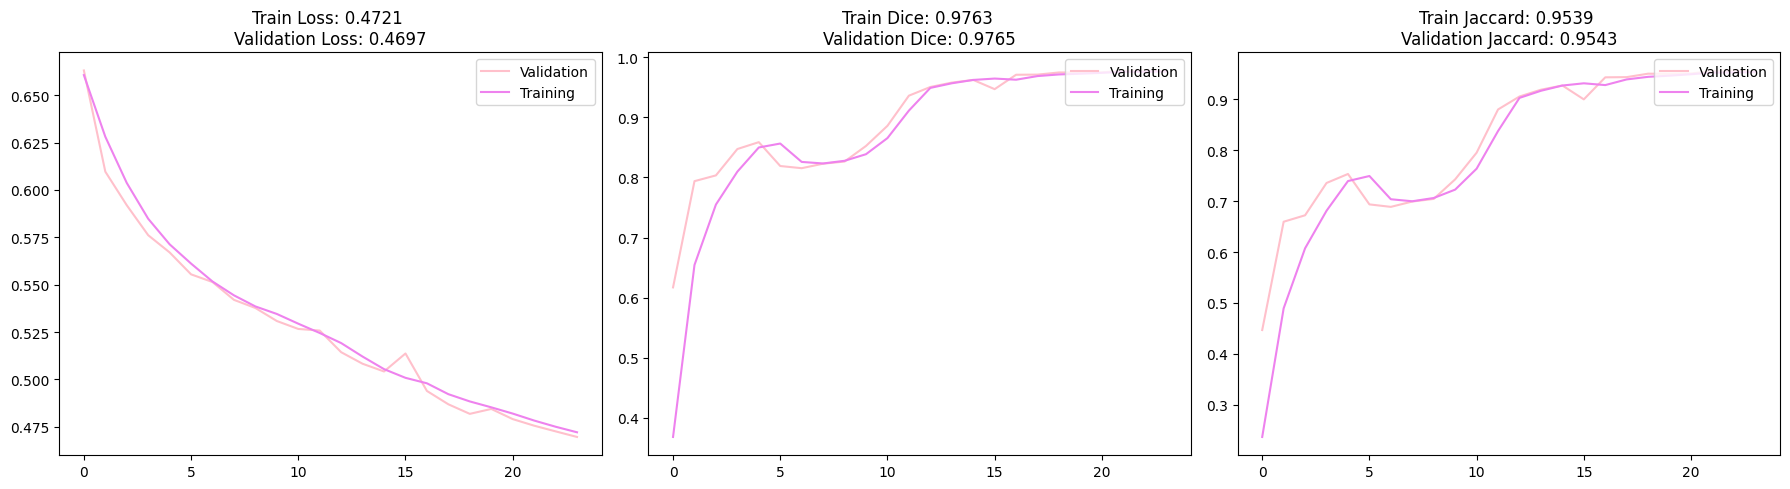

train epoch 25/30: 100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


Loss: 0.4690 | Dice: 0.9769 | IoU: 0.9551


val epoch 25/30: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Loss: 0.4646 | Dice: 0.9784 | IoU: 0.9581


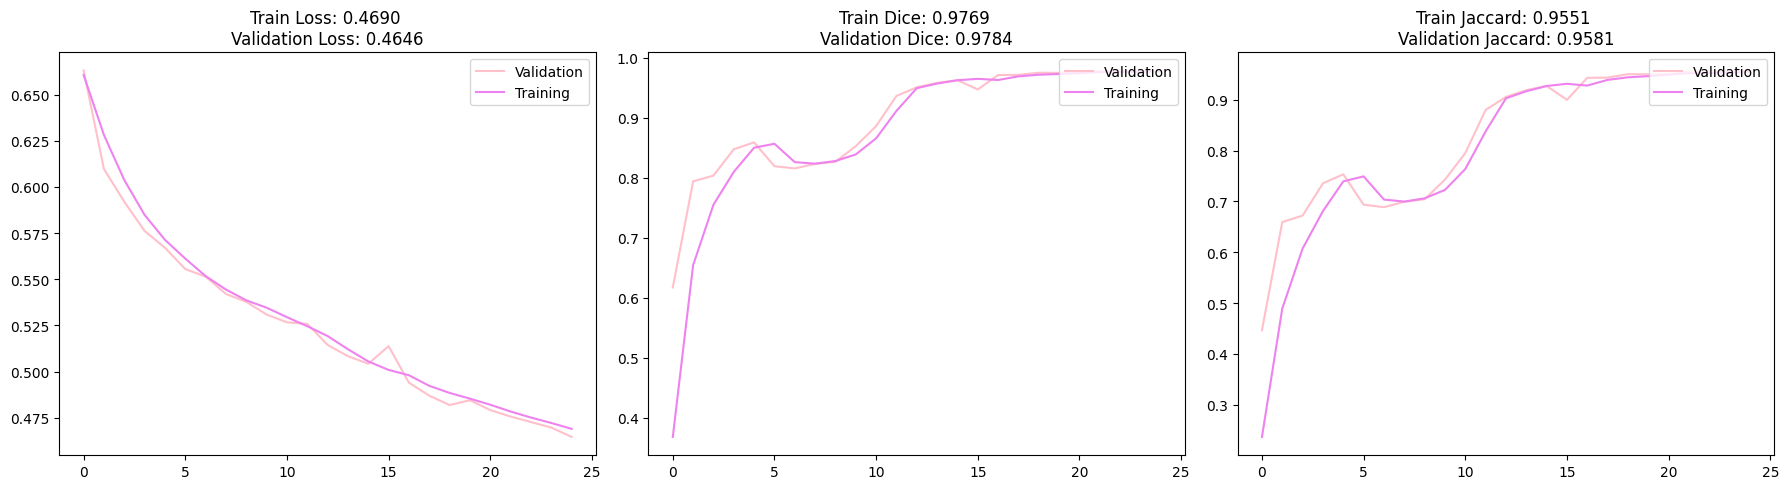

train epoch 26/30: 100%|██████████| 38/38 [00:28<00:00,  1.31it/s]


Loss: 0.4659 | Dice: 0.9784 | IoU: 0.9580


val epoch 26/30: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Loss: 0.4652 | Dice: 0.9774 | IoU: 0.9562


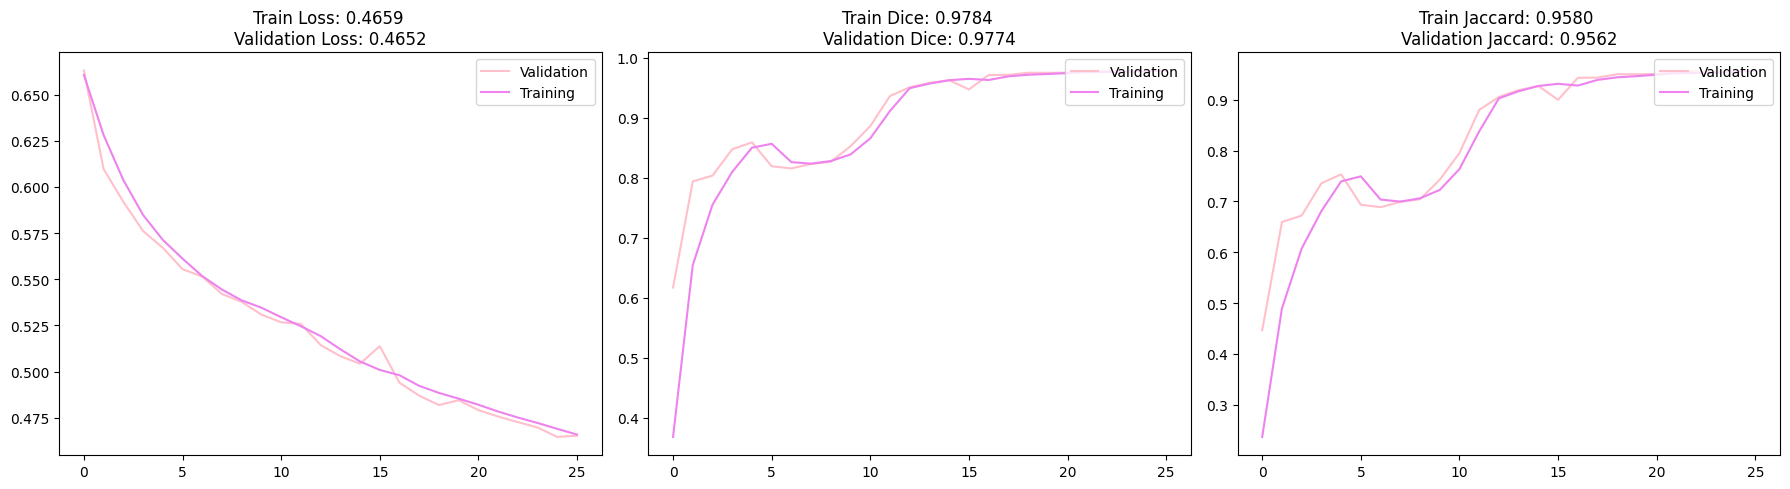

train epoch 27/30: 100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


Loss: 0.4631 | Dice: 0.9794 | IoU: 0.9600


val epoch 27/30: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Loss: 0.4657 | Dice: 0.9756 | IoU: 0.9529


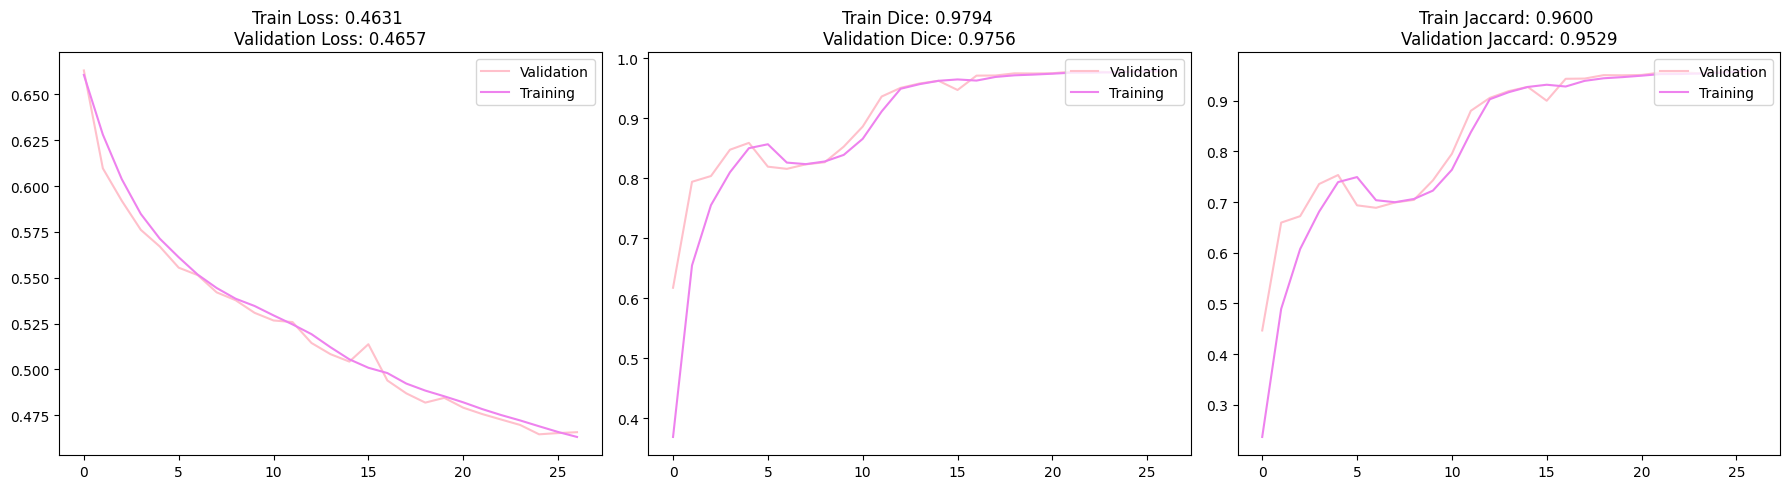

train epoch 28/30: 100%|██████████| 38/38 [00:28<00:00,  1.35it/s]


Loss: 0.4603 | Dice: 0.9805 | IoU: 0.9620


val epoch 28/30: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Loss: 0.4594 | Dice: 0.9808 | IoU: 0.9626


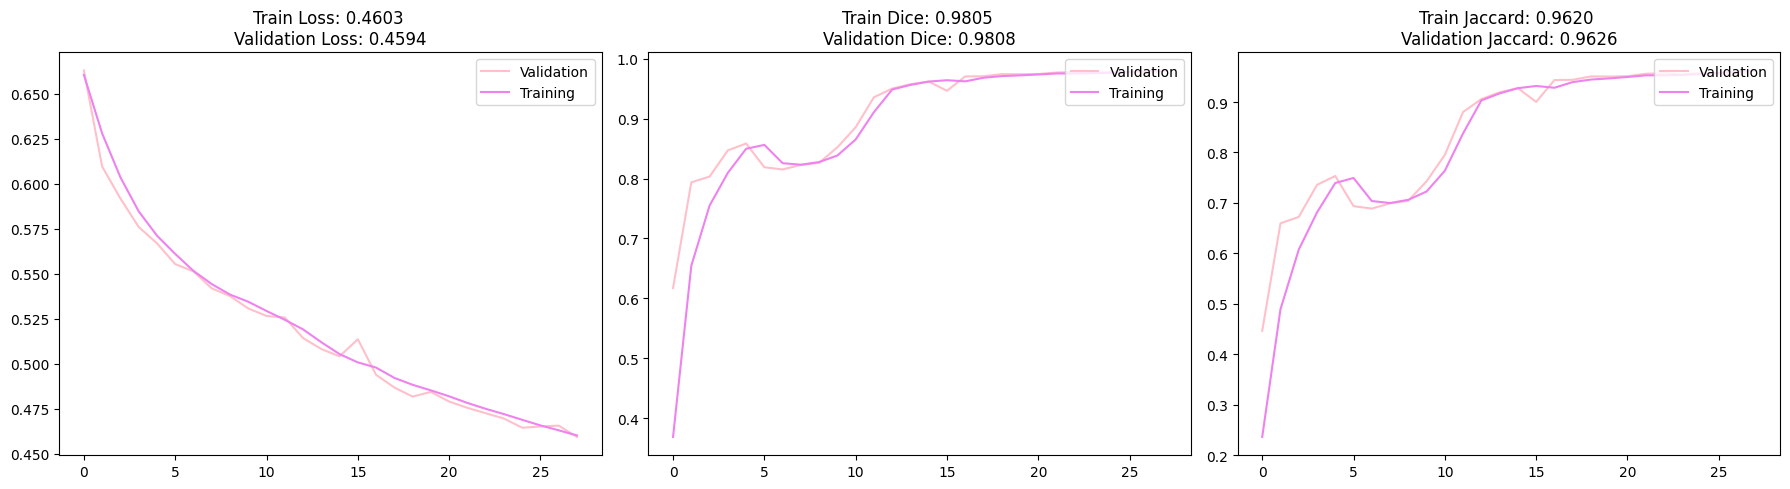

train epoch 29/30: 100%|██████████| 38/38 [00:28<00:00,  1.31it/s]


Loss: 0.4571 | Dice: 0.9811 | IoU: 0.9632


val epoch 29/30: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Loss: 0.4540 | Dice: 0.9818 | IoU: 0.9647


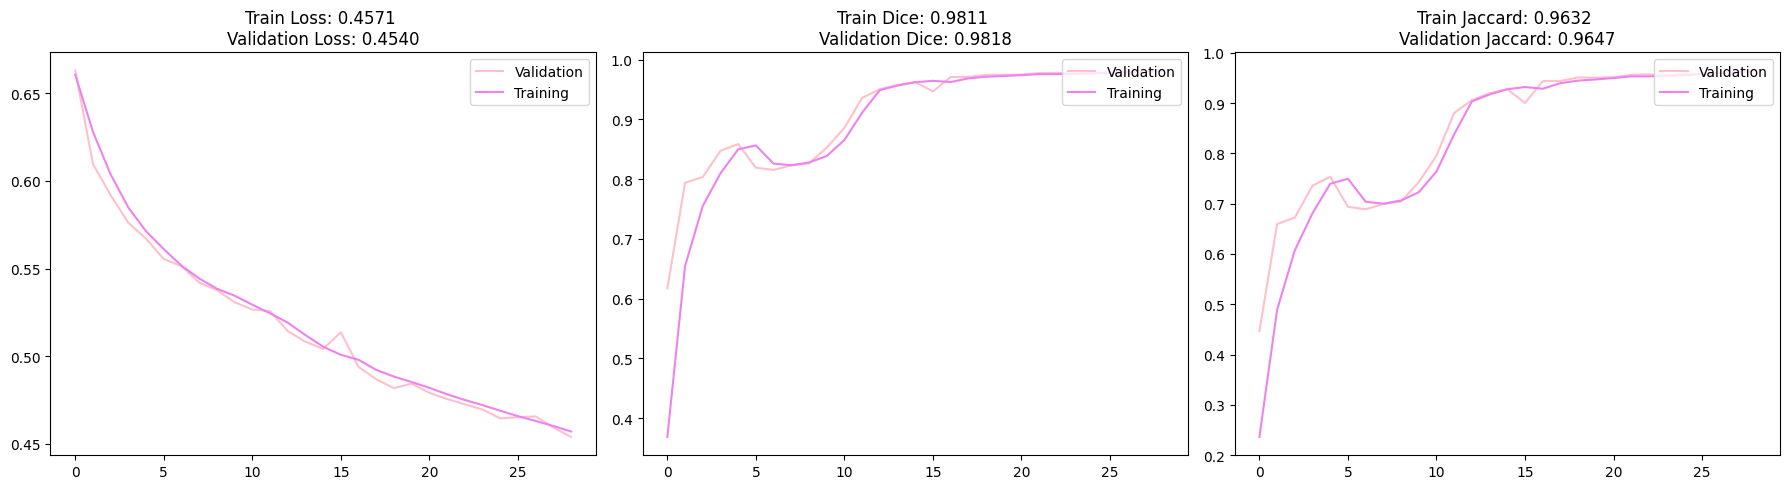

train epoch 30/30: 100%|██████████| 38/38 [00:29<00:00,  1.31it/s]


Loss: 0.4545 | Dice: 0.9813 | IoU: 0.9637


val epoch 30/30: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Loss: 0.4527 | Dice: 0.9823 | IoU: 0.9654


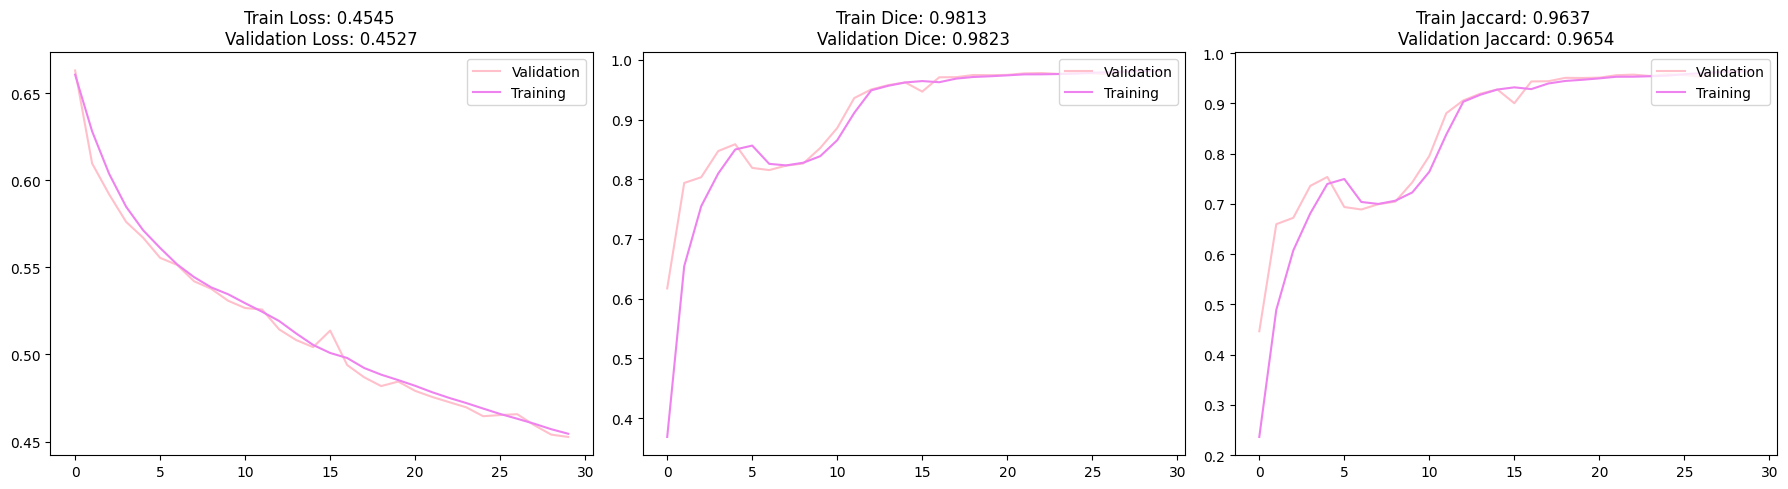


CPU times: user 13min 5s, sys: 39.4 s, total: 13min 44s
Wall time: 16min 20s


In [40]:
%%time
trainer.run()

In [41]:
def coef_metric_per_classes(probabilities, truth, threshold=0.5, eps=1e-9, classes=['WT', 'TC', 'ET', 'BG'], metric='dice'):
    scores = {key: [] for key in classes}
    predictions = (probabilities >= threshold).astype(np.float32)

    for i in range(probabilities.shape[0]):
        for class_, class_name in enumerate(classes):
            prediction = predictions[i, class_]
            truth_ = truth[i, class_]

            if metric == 'dice':
                intersection = 2.0 * np.sum(truth_ * prediction)
                union = np.sum(truth_) + np.sum(prediction)
            elif metric == 'jaccard':
                intersection = np.sum(prediction * truth_)
                union = np.sum(prediction) + np.sum(truth_) - intersection + eps
            else:
                raise ValueError("Unsupported metric. Use 'dice' or 'jaccard'.")

            if np.sum(truth_) == 0 and np.sum(prediction) == 0:
                scores[class_name].append(1.0)
            else:
                scores[class_name].append((intersection + eps) / (union + eps))

    return scores

def compute_scores_per_classes(model, dataloader, classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}
    loss_per_batch = []

    criterion = bce_dice_loss

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs.float())

            # Compute loss
            loss = criterion(logits, targets, alpha=0.5, beta=0.5)
            loss_per_batch.append(loss.item())

            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            dice_scores = coef_metric_per_classes(logits, targets, metric='dice')
            iou_scores = coef_metric_per_classes(logits, targets, metric='jaccard')

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    average_loss = sum(loss_per_batch) / len(loss_per_batch)

    return average_loss, dice_scores_per_classes, iou_scores_per_classes

In [42]:
model.eval();

In [43]:
average_test_loss, dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(model, test_dl, ['WT', 'TC', 'ET', 'BG'])

print(f"Average Test Loss: {average_test_loss:.4f}\n")

for key in dice_scores_per_classes.keys():
    print(f"Average Test Dice ({key}): {np.mean(dice_scores_per_classes[key]):.4f}")
print("\t")
for key in iou_scores_per_classes.keys():
    print(f"Average Test Jaccard ({key}): {np.mean(iou_scores_per_classes[key]):.4f}")

Average Test Loss: 0.4543

Average Test Dice (WT): 0.4559
Average Test Dice (TC): 0.2241
Average Test Dice (ET): 0.1406
Average Test Dice (BG): 0.9862
	
Average Test Jaccard (WT): 0.3710
Average Test Jaccard (TC): 0.2035
Average Test Jaccard (ET): 0.1397
Average Test Jaccard (BG): 0.9728


In [44]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice', 'BG dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard', 'BG jaccard']
test_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
test_metics_df = test_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard',
                                      'BG dice', 'BG jaccard']]
test_metics_df.sample(5)

WT dice  WT jaccard       TC dice    TC jaccard       ET dice  \
2   1.000000    1.000000  1.000000e+00  1.000000e+00  1.000000e+00   
28  0.610494    0.439361  1.772640e-01  9.725159e-02  5.586592e-12   
25  1.000000    1.000000  1.000000e-09  1.000000e-09  1.000000e+00   
34  0.682979    0.518578  1.428571e-10  1.428571e-10  7.518797e-12   
8   0.162665    0.088533  3.333333e-10  3.333333e-10  7.142857e-11   

      ET jaccard   BG dice  BG jaccard  
2   1.000000e+00  0.991579    0.983299  
28  5.586592e-12  0.981521    0.963713  
25  1.000000e+00  0.989970    0.980139  
34  7.518797e-12  0.984434    0.969344  
8   7.142857e-11  0.987091    0.974510

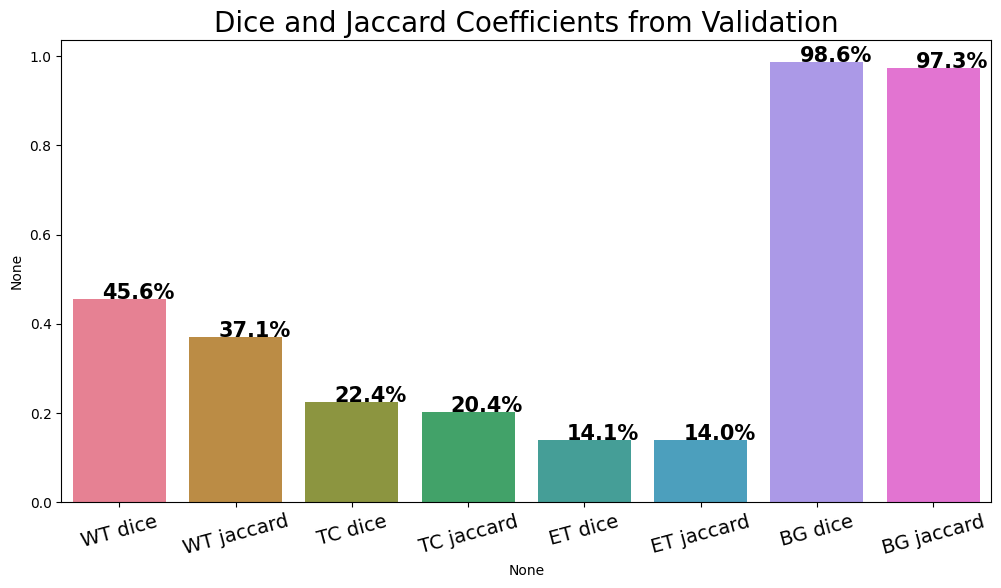

In [45]:
## Prosječne vrijednosti Dice i Jaccard koeficijenata za svaku od klasa na validacijskom skupu

unique_categories = test_metics_df.mean().index
palette = sns.color_palette("husl", len(unique_categories))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=test_metics_df.mean().index, y=test_metics_df.mean(), hue=test_metics_df.mean().index, palette=palette, ax=ax, legend=False)

ax.set_xticks(range(len(test_metics_df.mean().index)))
ax.set_xticklabels(test_metics_df.columns, fontsize=14, rotation=15)

ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * test_metics_df.mean().values[idx])
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

plt.show()

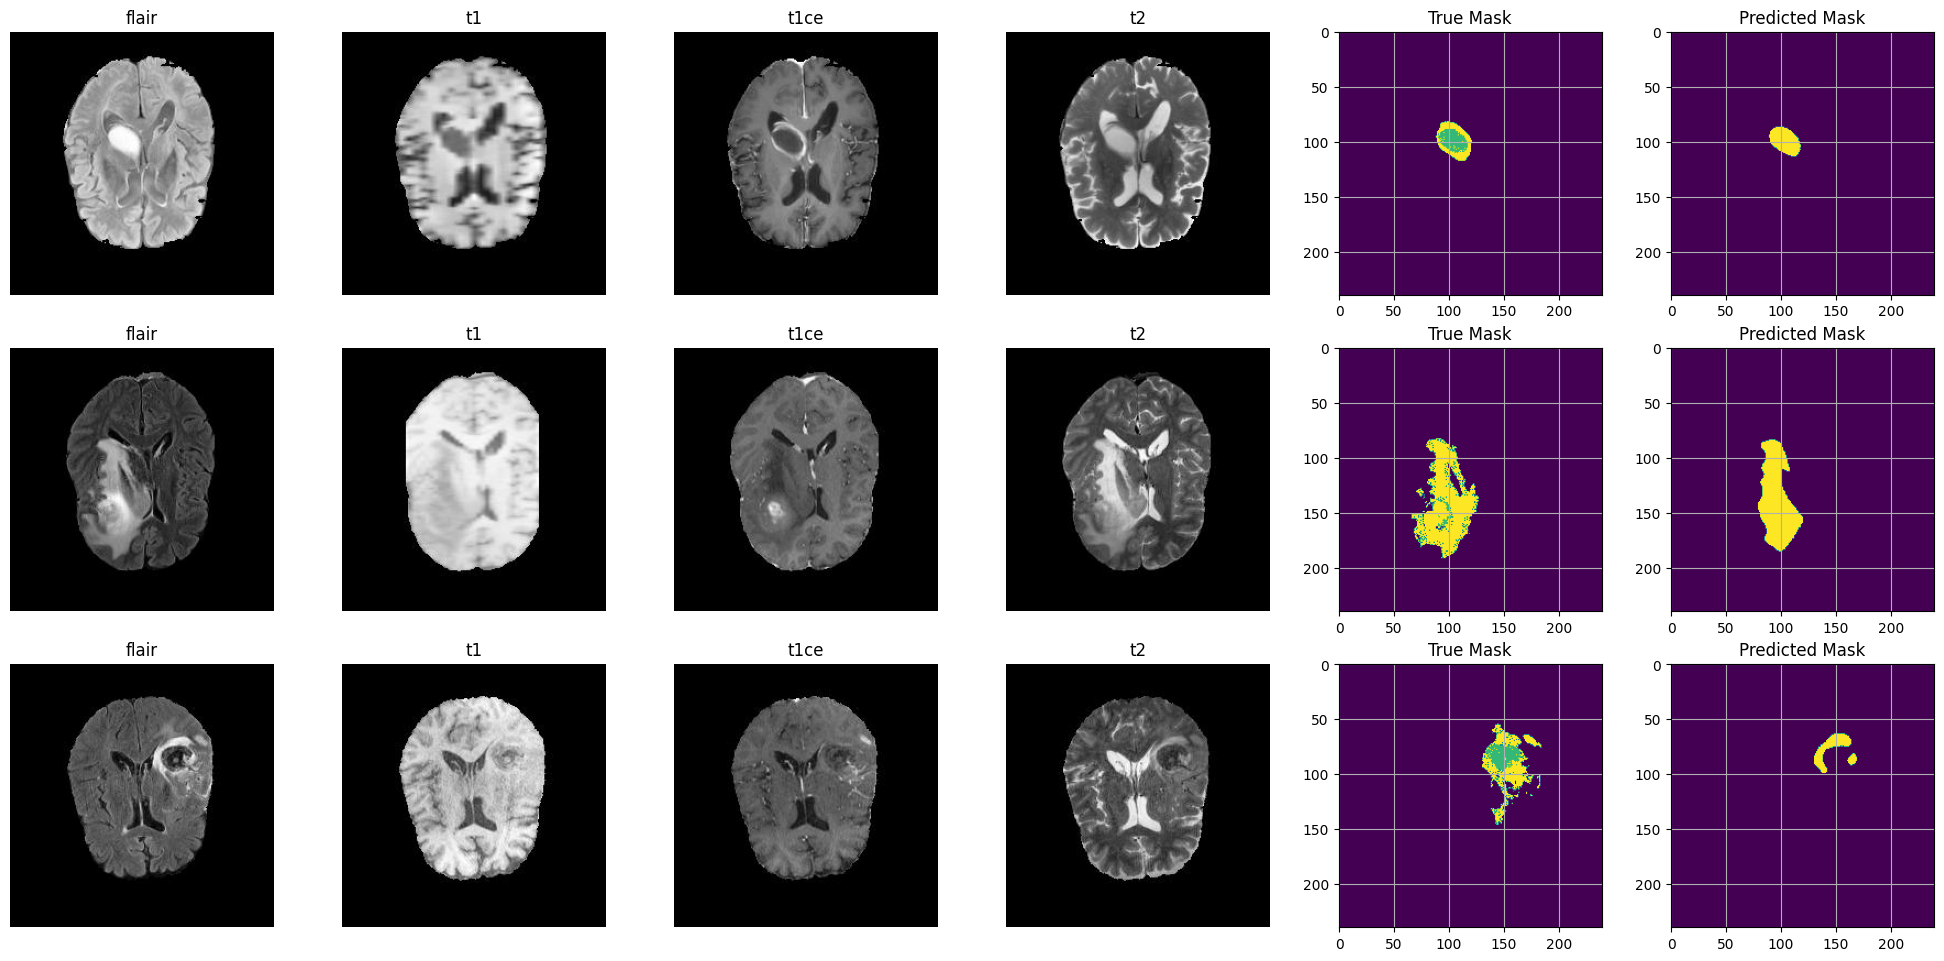

In [82]:
def show_results(model, test_dl):
    dl_iter = iter(test_dl)
    images, masks = next(dl_iter)

    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images.float())

    preds = torch.argmax(outputs, dim=1)
    masks = torch.argmax(masks, dim=1)

    plt.figure(figsize=(25, 65))

    for i in range(3):
        for j in range(len(modality_types)):
            plt.subplot(16, 6, 6 * i + j + 1)
            plt.axis('off')
            plt.title(modality_types[j])
            plt.imshow(images[i][j].cpu(), cmap='gray')

        plt.subplot(16, 6, 6 * i + 5)
        plt.title('True Mask')
        plt.grid()
        plt.imshow(255 - masks[i].cpu(), cmap='viridis')

        plt.subplot(16, 6, 6 * i + 6)
        plt.title('Predicted Mask')
        plt.grid()
        plt.imshow(255 - preds[i].cpu(), cmap='viridis')

    plt.show()

show_results(model, test_dl)